<a href="https://colab.research.google.com/github/jmontano1987/pdg/blob/main/Proyecto_de_Grado_version_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Proyecto de Grado**

**T√≠tulo:** Modelo para la detecci√≥n de Noticias Falsas en tweets con formato de texto en el contexto pol√≠tico colombiano para las elecciones del a√±o 2022.

**Integrantes:**
* Jesus Eduardo Flores Q.
* Juan Gabriel Monta√±o M.

#**Instalaciones**

In [ ]:
!pip install tweepy
!pip3 install tqdm
!pip install spacy
!pip install matplotlib
!pip install wordcloud
!pip install unidecode
!pip install scikit-plot
!pip install bayesian-optimization
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
!pip install stop-words

# paquetes necesarios para trabajar con BERT
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

#**Librerias**

In [ ]:
import io
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
import string
import tweepy
from tqdm.notebook import tqdm as tqdm_notebook
from dateutil import tz
from datetime import datetime 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import unidecode
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import requests
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import random
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
from google.colab import (
    drive,
    files
)
from tqdm import tqdm
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from stop_words import get_stop_words
import pickle
import xgboost as xgb
from sklearn.linear_model import PassiveAggressiveClassifier
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

#### 
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

## libreria para descargar un .zip desde una url de descarga
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import os


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#**Funciones**

In [ ]:
np.random.seed(42)
rng = np.random.RandomState(1)

In [ ]:
# al llamar la funci√≥n y pasarle una URL, descarga el arhcivo que debe estar en formato .zip y lo descomprime en la ruta content de colab
def download_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

In [ ]:
#Funcion que convierte el formato de la fecha del tweet en hora GMT -5 Colombia
def convert_date(str_date):
  str_format_date = '%Y-%m-%d %H:%M:%S' 
  from_zone = tz.gettz('UTC')
  to_zone = tz.gettz('America/Bogota')
  date_convert = datetime.strptime(str(str_date), str_format_date)
  date_convert = date_convert.replace(tzinfo=from_zone)
  date_convert = date_convert.astimezone(to_zone)
  date_convert = datetime.strftime(date_convert,'%d/%m/%Y %H:%M:%S')
  return date_convert

In [ ]:
#Funcion para obtener los tweets de un usuario especifio de twitter - Se quitan los RT
def get_tweets(api,username,items,rts):
  tweets={}
  for tweet in tqdm_notebook(tweepy.Cursor(api.user_timeline, screen_name = username, tweet_mode='extended',include_rts=rts).items(items)):
      tweets[tweet.id]= {
          'full_text': tweet.full_text,
          'created_at': convert_date(tweet.created_at),
          'author_name': tweet.user.name,
          'author_handler': str(tweet.user.screen_name),
          'user_description': tweet.user.description,
          'user_location': tweet.user.location,
          'user_followers_count': tweet.user.followers_count,
          'user_created_at': convert_date(tweet.user.created_at),
          'user_following_count': tweet.user.friends_count,
          'user_verified': tweet.user.verified,
          'lang': tweet.lang,
          'tweet_hashtags': tweet.entities['hashtags'],
          'mention_names': ["@" + d['screen_name'] for d in tweet.entities['user_mentions'] if 'screen_name' in d],
          'mention_ids': [d['id'] for d in tweet.entities['user_mentions'] if 'id' in d],
          'n_retweets': tweet.retweet_count,
          'n_favorites': tweet.favorite_count,
          'is_retweet': hasattr(tweet, 'retweeted_status')
      }
  df_tweets = pd.DataFrame.from_dict(tweets, orient='index')
  df_tweets['id'] = df_tweets.index
  return df_tweets

In [ ]:
def remove_newlines_tabs(text):
 # Remover saltos de linea
  formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ')
  return formatted_text

In [ ]:
def remove_whitespace(text):
  # Remover espacios en blanco
    pattern = re.compile(r'\s+') 
    without_whitespace = re.sub(pattern, ' ', text)
    text = without_whitespace.replace(')', ') ')
    text=text.replace("  ", " ").replace("   ", " ").replace("    ", " ").lstrip()
    text=text.replace("  ", " ").replace("   ", " ").replace("    ", " ").rstrip()
    text=text.replace("   ", "")
    return text    

In [ ]:
def accented_characters_removal(text):
  # Remover tildes
    text = unidecode.unidecode(text)
    return text

In [ ]:
def remove_special_characters(text):
    # Remover caracteres especiales
    return text.translate(str.maketrans('','',string.punctuation))

In [ ]:
def lower_text(text):
    # Convertir mayusculas a minusculas
    text = text.lower()
    return text

In [ ]:
stoplist = list(get_stop_words('spanish'))  # 308 words
nltk_words = list(stopwords.words('spanish')) #
stoplist.extend(nltk_words)
def remove_stopwords(text):
    # Remover stop words
    nostopwords = [word for word in word_tokenize(text) if word.lower() not in stoplist ]
    # Convertir lista en tipo String
    words_string = ' '.join(nostopwords)   
    return words_string

In [ ]:
nlp = spacy.load('en_core_web_sm')
def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

In [ ]:
def remove_links(text): 
    # Remover urls 
    text=re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+",'',text)
    text=re.sub(r'https?://\S+|www\.\S+','',text)
    text=re.sub(r'opr-littps://S+','',text)
    return text

In [ ]:
def remove_numbers(text):
    # Remover numeros
    formatted_text=''.join((x for x in text if not x.isdigit()))
    formatted_text= re.sub(r"NUMBER", ' ', formatted_text)
    formatted_text= re.sub(r"number", ' ', formatted_text)
    return formatted_text

In [ ]:
def text_preprocessing(text, accented_chars=True, newlines_tabs=True, extra_whitespace=True,lowercase=True,characters_specials=True,stop_words=True,lemmatization = True,links=True,numbers_remove=True):     

    if newlines_tabs == True:  # Remover saltos de linea
        data = remove_newlines_tabs(text) 
   
    if links == True: #remove links
        data = remove_links(data)
        
    if extra_whitespace == True: # Remover espacios en blanco
        data = remove_whitespace(data)
    
    if lowercase == True: # Convertir mayusculas a minusculas
        data = lower_text(data)
    
    if characters_specials == True: # Remover signos de puntuaci√≥n
        data = remove_special_characters(data)

    if numbers_remove == True: # Remover n√∫meros
        data = remove_numbers(data)

    if accented_chars == True: # Remover tildes
        data = accented_characters_removal(data) 

    if stop_words == True: # Remover stopwords
        data = remove_stopwords(data) 

    if lemmatization == True: # Lematizacion
       data = lemmatizer(data)

    if characters_specials == True: # Remover caracteres especiales
        data = remove_special_characters(data)

    if extra_whitespace == True: # Remover espacios en blanco
        data = remove_whitespace(data)    
       
    return data

In [ ]:
def change_categories(campo):
    if campo=='True' or campo=='Noticia Real' or campo=='0':
        return 'Noticia Real'
    else:
        return 'Noticia Falsa'

In [ ]:
def create_model_production(name_model,model):
  with open(name_model+'.pkl','wb') as model_pkl:
    pickle.dump(model, model_pkl, protocol=2)

In [ ]:
def randomsearchmodels(model,hyperparameters_tuning,features_train_f,labels_train_f,features_test_f,labels_test_f):
  gridsearch = RandomizedSearchCV(model,hyperparameters_tuning,n_iter=10,scoring='accuracy',cv=3,verbose=1,random_state=8)
  gridsearch.fit(features_train_f,labels_train_f)
  predictions = gridsearch.predict(features_test_f)
  accuracy_model=accuracy_score(predictions, labels_test_f)
  return gridsearch,predictions,accuracy_model

In [ ]:
def tifdf_features (X_train, X_test, y_train, y_test,ngram_range,max_df,min_df,max_features):
  tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
  features_train = tfidf.fit_transform(X_train)
  features_test = tfidf.transform(X_test)
  labels_train = y_train
  labels_test = y_test
  return features_train,features_test,labels_train,labels_test,tfidf

In [ ]:
def removeFinalSpace(x):
    if type(x)==str:
        return x.lstrip()
    else:
        return x

In [ ]:
# removerlos al final  
def removeInitSpace(x):
    if type(x)==str:
        return x.rstrip()
    else:
        return x

In [ ]:
#@title Seleccione el modelo de BERT para el fine-tune
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'distilbert_multi_cased_L-6_H-768_A-12':
      'https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'distilbert_multi_cased_L-6_H-768_A-12':
      'https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


#**Twitter**

Credenciales Consumo API

In [ ]:
# API Keys para autenticacion
api_key = "UcZ9gR5yMV4MlKTFaSwhC1aNX" 
api_secret = "R5BjKcmHan6MGaX98UMhytQfLiZI7TLl9AATGtixJLwmAU2DFR"
access_token = "1452452402070794241-rKitK0leSslMs9XoXEDBTxOwplOGGU"
access_token_secret = "lBAxKokr4Hkg3DxvaUMTWkAqU0E9O5KfZCmJoPulnfSRn"

In [ ]:
# Autorizaci√≥n para consumo API
auth = tweepy.OAuthHandler(api_key, api_secret) 
# Acceso al API
auth.set_access_token(access_token, access_token_secret) 
# Instancia para llamar a la API 
api = tweepy.API(auth, wait_on_rate_limit=True) 

NameError: ignored

In [ ]:
#Obtener Tweets de cuenta
df_tweets=get_tweets(api,"cnnee",10,False)

In [ ]:
df_tweets.full_text.iloc[0]

#**Cargar Corpus**

In [ ]:
url_archivos='https://docs.google.com/uc?export=download&id=10c_3sI5gDKl5GCyo1Aea34DhRWdTUya6'
download_unzip(url_archivos)

In [ ]:
%%time
# opcionalmente se pueden cargar los archivos de trabajo desde el area de trabajo local. Estos se deben cargar previamente 
df=pd.read_excel("files/Corpus_Noticias_Falsas.xlsx")
df2=pd.read_excel("files/train.xlsx")
df3=pd.read_csv("files/fakes2000.csv", skipinitialspace=True, skip_blank_lines=True, encoding='utf-8')
df_testNoticiasMejicanas=pd.read_excel("files/testNoticiasColombianas.xlsx")
df_stopwords=pd.read_csv("files/spanish.txt")
#df_testNoticiasColombianas=pd.read_excel("fakeNewsColombia.xlsx")

CPU times: user 532 ms, sys: 10.8 ms, total: 542 ms
Wall time: 558 ms


In [ ]:
df=df[['Categoria','Texto']] # Corpus creado por Eduardo Flores y Juan Montano
df

Categoria                                              Texto
0    Noticia Real  El presidente Iv√°n Duque conden√≥ fuertemente e...
1    Noticia Real  Gustavo Petro se reunir√° con Pedro S√°nchez, pr...
2    Noticia Real  Marta Luc√≠a Ram√≠rez se queja por servicio en e...
3    Noticia Real  Elecciones de 2022 requieren mayor cuidado, po...
4    Noticia Real  ANTE LA expansi√≥n de la variante √≥micron en el...
..            ...                                                ...
629  Noticia Real  Consejo Nacional Electoral pide auditor√≠a de s...
630  Noticia Real  Registrador Nacional anuncia cambios en formul...
631  Noticia Real  Gobernaci√≥n del Valle acompa√±a a la Registradu...
632  Noticia Real  Autoridades ratifican medidas de seguridad par...
633  Noticia Real  ¬øNueva alianza? Ingrid Betancourt estar√≠a disp...

[634 rows x 2 columns]

In [ ]:
#stoplist.clear() : funcion para borra el contenido de la lista
stoplist.extend(df_stopwords['stopwords'].tolist())
len(stoplist)

1229

In [ ]:
# eliminar las tildes de los stopword para la limpieza.
list_stop_words = []
for n in stoplist:
  list_stop_words.append(unidecode.unidecode(n))
stoplist=list_stop_words

In [ ]:
df.value_counts(df['Categoria'])

Categoria
Noticia Falsa    317
Noticia Real     317
dtype: int64

In [ ]:
## seleccionar las dos columans de trabajo
df2=df2[['Category','Text']] # Corpus Posadas-Duran
df2

Category                                               Text
0       Fake  RAE INCLUIR√Å LA PALABRA "LADY" EN EL DICCIONAR...
1       Fake  La palabra "haiga", aceptada por la RAE La Rea...
2       Fake  YORDI ROSADO ESCRIBIR√Å Y DISE√ëAR√Å LOS NUEVOS L...
3       True  UNAM capacitar√° a maestros para aprobar prueba...
4       Fake  Alerta: pretenden aprobar libros escolares con...
..       ...                                                ...
671     Fake  Madonna ser√° la nueva imagen del Chocolate Abu...
672     True  Filtran material √≠ntimo de Zelina Vega, luchad...
673     Fake  CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...
674     Fake  TV Azteca anuncia que cambiar√° su nombre por u...
675     Fake  MUERTE DE PETER EL ANGUILA POR SOBREDOSIS\nPet...

[676 rows x 2 columns]

In [ ]:
# se renombran las columas para realizar la union de los dos corpus
df2=df2.rename(columns={'Category':'Categoria', 'Text':'Texto'})

In [ ]:
df2.value_counts('Categoria')

Categoria
Fake    338
True    338
dtype: int64

In [ ]:
## corpus de 2000 noticias (Fake2000), se nombra como df3 ya que tenemos 3 corpus por unir
df3

class                                               Text
0      True   Algunas de las voces extremistas m√°s conocida...
1      True   Despu√©s de casi dos a√±os y medio de luchas po...
2      True  Dos periodistas birmanos de la agencia Reuters...
3      True  El Cuerpo Nacional de Polic√≠a ha detenido a cu...
4      True  El desfile de la firma en Roma se convierte en...
...     ...                                                ...
1995   True   El Consejo de Gobierno ha dado su visto bueno...
1996   True   Investigadores valencianos han desarrollado u...
1997   True   Los arrestados actuaban en coches y en establ...
1998   True   El Rey ha encargado este mi√©rcoles a Pedro S√°...
1999   True   Las pruebas realizadas en el Centro Nacional ...

[2000 rows x 2 columns]

In [ ]:
# visualizar la tabla de frecuencias de las categorias. Las etiquetas se encuentran balanceadas.
df3['class'].value_counts()

True     1000
False    1000
Name: class, dtype: int64

In [ ]:
# renombramos las columnas para que queden todas con igual nombre, de esta manera se realiza correctamente la concatenaci√≥n.
df3=df3.rename(columns={'class':'Categoria', 'Text':'Texto'})

In [ ]:
#Dataframe con 600 noticias
df_base_cp=df

In [ ]:
#Union de los dos tres corpus
df_base=pd.concat([df,df2,df3], axis=0, ignore_index=False)

In [ ]:
# visualizaci√≥n de como queda el corpus de 3173 noticias.
df_base

Categoria                                              Texto
0     Noticia Real  El presidente Iv√°n Duque conden√≥ fuertemente e...
1     Noticia Real  Gustavo Petro se reunir√° con Pedro S√°nchez, pr...
2     Noticia Real  Marta Luc√≠a Ram√≠rez se queja por servicio en e...
3     Noticia Real  Elecciones de 2022 requieren mayor cuidado, po...
4     Noticia Real  ANTE LA expansi√≥n de la variante √≥micron en el...
...            ...                                                ...
1995          True   El Consejo de Gobierno ha dado su visto bueno...
1996          True   Investigadores valencianos han desarrollado u...
1997          True   Los arrestados actuaban en coches y en establ...
1998          True   El Rey ha encargado este mi√©rcoles a Pedro S√°...
1999          True   Las pruebas realizadas en el Centro Nacional ...

[3310 rows x 2 columns]

In [ ]:
# se observa que las clases True estan siendo leidas de forma diferente(problema por resolver)
df_base.Categoria.value_counts()

True             1000
False            1000
Fake              338
True              338
Noticia Real      317
Noticia Falsa     317
Name: Categoria, dtype: int64

In [ ]:
# para mitigar temporalmente el error, se exporta el archivo .csv (de esta manera se formatean los datos).
df_base.to_csv('salida.csv')

In [ ]:
# nuevamente se realiza la lectura del corpus (soluci√≥n temporal)
df_base=pd.read_csv('salida.csv')

In [ ]:
# Se observa como la categoria True ya fue leida como una sola. Pso siguiente Unificar las categorias.
df_base.Categoria.value_counts()

True             1338
False            1000
Fake              338
Noticia Real      317
Noticia Falsa     317
Name: Categoria, dtype: int64

In [ ]:
# cambiar el nombre de la categoria para dejar el corpus uniforme: Fake=Noticia Falsa, True=Noticia Real
df_base["Categoria"]=df_base["Categoria"].apply(change_categories)
df_base

Unnamed: 0     Categoria  \
0              0  Noticia Real   
1              1  Noticia Real   
2              2  Noticia Real   
3              3  Noticia Real   
4              4  Noticia Real   
...          ...           ...   
3305        1995  Noticia Real   
3306        1996  Noticia Real   
3307        1997  Noticia Real   
3308        1998  Noticia Real   
3309        1999  Noticia Real   

                                                  Texto  
0     El presidente Iv√°n Duque conden√≥ fuertemente e...  
1     Gustavo Petro se reunir√° con Pedro S√°nchez, pr...  
2     Marta Luc√≠a Ram√≠rez se queja por servicio en e...  
3     Elecciones de 2022 requieren mayor cuidado, po...  
4     ANTE LA expansi√≥n de la variante √≥micron en el...  
...                                                 ...  
3305   El Consejo de Gobierno ha dado su visto bueno...  
3306   Investigadores valencianos han desarrollado u...  
3307   Los arrestados actuaban en coches y en establ...  
3308   El Rey ha encargado este mi√©rcoles a Pedro S√°...  
3309   Las pruebas realizadas en el Centro Nacional ...  

[3310 rows x 3 columns]

In [ ]:
# Conteo del numero de noticias falsas y verdaderas. Se observa que ahora si quedaron balanceadas.
df_base.Categoria.value_counts()

Noticia Real     1655
Noticia Falsa    1655
Name: Categoria, dtype: int64

In [ ]:
#Dataframe con 1000 noticias - Union Corpus JM y Posadas-Duran
df_merge=df_base

#**Preprocesamiento**

Tareas de pre-procesamiento a realizar:
* Convertir Mayusculas a minusculas
* Remover links
* Remover n√∫meros
* Remover signos de puntuaci√≥n
* Remover tildes
* Remover comillas
* Remover retornos y lineas nuevas
* Remover StopWords
* Lematizaci√≥n

### **Preprocesamiento Corpus del proyecto**

In [ ]:
#Preprocesamiento Corpus 634 noticias
List_News = df_base_cp['Texto'].to_list()
Final_News = []
Complete_Content = []
for news in tqdm(List_News):
    Processed_Content = text_preprocessing(news)
    Final_News.append(Processed_Content)
Complete_Content.extend(Final_News)
df_base_cp['Processed_Text'] = Complete_Content

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 634/634 [00:09<00:00, 68.97it/s]


### **Preprocesamiento Corpus Mejorado**



In [ ]:
#Preprocesamiento Corpus 1000 noticias
List_News = df_merge['Texto'].to_list()
Final_News = []
Complete_Content = []
for news in tqdm(List_News):
    Processed_Content = text_preprocessing(news)
    Final_News.append(Processed_Content)
Complete_Content.extend(Final_News)
df_merge['Processed_Text'] = Complete_Content

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3310/3310 [01:07<00:00, 49.09it/s] 


In [ ]:
df_merge.Texto.iloc[1093]

'SIN ESCAPATORIA: INTERPOL presenta las pruebas de que Carlos Salinas si mat√≥ a COLOSIO\nLuis Donaldo Colosio Murrieta recibi√≥ un segundo disparo en la camioneta a bordo de la cual fue trasladado al hospital despu√©s de haber sido herido en la cabeza en Lomas Taurinas, Tijuana. Esto lo establece una videograbaci√≥n aportada por la Universidad de Guadalajara.\nLa grabaci√≥n es prueba indiscutible de que Luis D. Colosio fue v√≠ctima de un complot en el que estar√≠an involucrados miembros del Estado Mayor Presidencial que ten√≠an a su cargo la seguridad de Colosio, encabezados por el general brigadier Domiro Roberto Garc√≠a Reyes. La grabaci√≥n fue desvelada por el noticiario Esferas, que se trasmite en la ciudad de Guadalajara, capital del estado de Jalisco, donde acaba de tener lugar la III cumbre de la Uni√≥n Europea y Am√©rica Latina.\nLa videograbaci√≥n fue revelada al p√∫blico al cumplirse *NUMBER* a√±os del crimen del entonces candidato a la Presidencia de la Rep√∫blica, y en ell

In [ ]:
a="Carlos Trejo producir√°, dirigir√° y protagonizar√° la versi√≥n mexicana de Los Cazafantasmas M√©xico.- El investigador de fen√≥menos paranormales, Carlos Trejo, anunci√≥ que en mayo iniciar√° el rodaje de la versi√≥n mexicana de la pel√≠cula \"Los Cazafantasmas\", cinta que √©l producir√°, dirigir√° y protagonizar√° junto con otros reconocidos actores nacionales.\nTrejo mencion√≥ que ‚Äìa diferencia del film original- su pel√≠cula tratar√° el tema de los fantasmas de manera seria y respetuosa, y no con las \"payasadas\" de la versi√≥n americana:\n\"Como ya todos saben yo estuve a punto de morir por culpa de un espectro del m√°s all√° que atorment√≥ a mi familia cuando viv√≠amos en Ca√±itas. Las situaciones paranormales son un tema serio y delicado, me parece una groser√≠a que Hollywood saque una pel√≠cula buf√°ndose de esta terrible situaci√≥n, eso demuestra que no les importa hacer cine de calidad, prefieren producir pel√≠culas tontas y huecas con tal de llenarse los bolsillos de dinero en vez de realizar cine de calidad\", se√±al√≥.\nCarlos mencion√≥ que no es uh novato en el cine ya que su libro \"Ca√±itas\" fue adaptado a la pantalla grande en el *NUMBER*:\n\"Siempre tuve la espinita de producir pel√≠culas de calidad para engrandecer a nuestro nacional. Ahora que Hollywood va a estrenar la versi√≥n femenina de los Cazafantasmas quise producir la versi√≥n mexicana para demostrarles que nuestro cine tiene much√≠sima mejor calidad y es m√°s profundo. Quiero hacer de esta pel√≠cula toda una obra de arte\", se√±al√≥.\nTrejo mencion√≥ que su pel√≠cula ser√° un drama y no comedia, adem√°s de que los cazafantasmas de su film intentar√°n atrapar espectros reales que √©l ha conocido:\n\"Los fantasmas que ver√°n en mi cinta ser√°n fantasmas reales con los que he convivido a trav√©s de los a√±os. Mi pel√≠cula ser√° una especie de documental que le mostrar√° al mundo que no estamos solos y que estos espectros son peligrosos, pero que afortunadamente hay personas como yo que estamos dispuesto a dar la vida con tal de controlarlos para que no da√±en al mundo\", se√±al√≥.\nPor √∫ltimo, Trejo confirm√≥ que el grupo de cazafantamas mexicanos estar√° integrado (adem√°s de √©l) por los actores Adri√°n Uribe, Omar Chaparro, Martha Higareda (la √∫nica mujer en el grupo) y el investigador en fen√≥menos extraterrestres Jaime Maussan, con quien recientemente hizo las pases."
b=unidecode.unidecode(a,'utf-8')
c=remove_special_characters(b)
d=remove_stopwords(c)
d

'Carlos Trejo producira dirigira protagonizara version mexicana Cazafantasmas Mexico investigador fenomenos paranormales Carlos Trejo anuncio mayo iniciara rodaje version mexicana pelicula Cazafantasmas cinta producira dirigira protagonizara reconocidos actores nacionales Trejo diferencia film original pelicula tratara tema fantasmas respetuosa payasadas version americana punto morir culpa espectro alla atormento familia viviamos Canitas situaciones paranormales tema serio delicado groseria Hollywood saque pelicula bufandose terrible situacion demuestra importa cine calidad prefieren producir peliculas tontas huecas llenarse bolsillos dinero cine calidad Carlos uh novato cine libro Canitas adaptado pantalla grande NUMBER espinita producir peliculas calidad engrandecer nacional Hollywood estrenar version femenina Cazafantasmas quise producir version mexicana demostrarles cine muchisima calidad profundo Quiero pelicula obra arte Trejo pelicula drama comedia cazafantasmas film intentaran 

In [ ]:
df_base_cp.Processed_Text.iloc[400]

'atencion noticia hombre identificado alias naruto personas coloco carro bomba academia policia bogota difundir quepagueporloquehizo'

In [ ]:
df_merge.Processed_Text.iloc[200]

'ola atracos viene presentando area metropolitana bucaramanga extranjeros medio comunicacion comunica amanda duarte representante extranjeros santander pronuncio respeto gobierno diera subsidio mensual diera vivir mercado vivir colegas robaran mentalidad extranjeros dinero pais dia pais cambie dia llevamos dinero hagamos colombia gobierno colombia incumplio casa vivir beca estudiar colegas toca robar dinero pais'

In [ ]:
df_merge.Processed_Text.iloc[1000]

'pedro sanchez anuncia iniciativa conjunta congreso desmantelar politicas pp discurso militante delegado psoe pedro sanchez anunciado aprovechara minoria pp congreso crear iniciativa resto fuerzas politicas permita desarticular leyes aprobadas gobierno rajoy psoe apoya ejecutiva sanchez votos secretario general psoe referido espacio coordinacion parlamentaria fuerzas cambio fuerzas refiere ciudadanos advierte continuan vetos mutuos unico voto util psoe sanchez agradecido patxi lopez susana diaz actitud proceso primarias olvidado alocucion principio discurso referido personas formaron m reunieron anos puerta sol madrid grito representan nicho nacio desarrollo tomado mensaje sanchez aclamacion congreso federal socialista alli dirigido llamada busqueda recuperar votante perdidos psoe anos izquierda gobierno representar anos representan quedado claro sanchez reiterado posteriormente unico competidor unico partido medirse partido popular mira frente competimos partido popular descanso mayor

In [ ]:
df_merge.Processed_Text.iloc[1093]

'escapatoria interpol presenta pruebas carlos salinas mato colosio luis donaldo colosio murrieta recibio disparo camioneta bordo trasladado hospital herido cabeza lomas taurinas tijuana establece videograbacion aportada universidad guadalajara grabacion prueba indiscutible luis d colosio victima complot involucrados miembros presidencial cargo seguridad colosio encabezados general brigadier domiro roberto garcia reyes grabacion desvelada noticiario esferas trasmite ciudad guadalajara capital jalisco acaba iii cumbre union europea america latina videograbacion revelada publico cumplirse anos crimen candidato presidencia republica camara lenta aprecia caos traslado victima sitio disparo cabeza camioneta usaba gira intromision escena extranos videograbaciones obtenidas crisis pagina web noticiario jaliciense demuestra colosio herido subido camioneta portezuela derecha trasera conductor noticiero senala observen individuo camioneta tipo corta estatura lente pelon ve portezuela trasera izqu

###**Divisi√≥n del Corpus - Noticias Falsas y Verdaderas**

In [ ]:
#Divisi√≥n Dataframe Corpus de referencia
real_news = df_merge[df_merge['Categoria'] == 'Noticia Real']
fake_news = df_merge[df_merge['Categoria'] == 'Noticia Falsa']

In [ ]:
#Divisi√≥n Dataframe Corpus creado
real_news_cp=df_base_cp[df_base_cp['Categoria'] == 'Noticia Real']
fake_news_cp = df_base_cp[df_base_cp['Categoria'] == 'Noticia Falsa']

# **Analitica Descriptiva**

## **Analitica Corpus Propio**

###**Histograma de categorias**

In [ ]:
# Distribuci√≥n de noticias falsas y verdaderas Corpus 500 noticias
ax = sns.countplot(x="Categoria", data=df_base_cp)

### Word Cloud Real News Corpus Propio

In [ ]:
#Wordcloud 500 Noticias reales
wc = WordCloud(background_color="white", max_words=3000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(real_news_cp['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Real News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Cloud Fake News Corpus Propio

In [ ]:
#Wordcloud 500 noticias falsas
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(fake_news_cp['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Fake News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Analitica Corpus Mejorado**

###**Histograma de categorias**

In [ ]:
# Distribuci√≥n de noticias falsas y verdaderas Corpus 1000 noticias
ax = sns.countplot(x="Categoria", data=df_merge)

### Word Cloud Fake News Corpus Mejorado

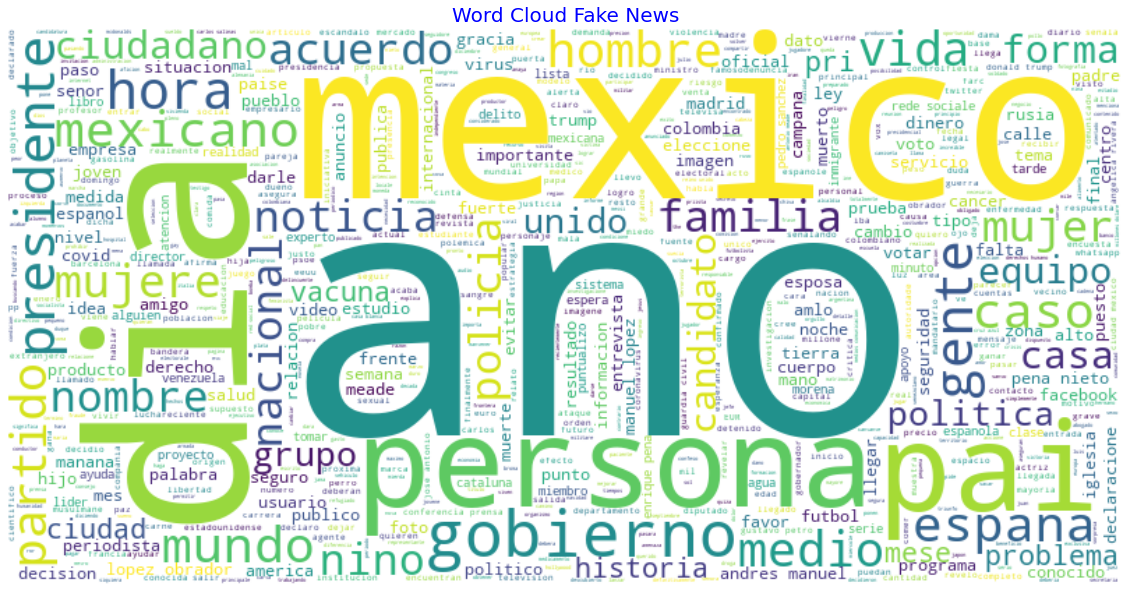

In [ ]:
#Wordcloud 1000 noticias falsas
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(fake_news['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Fake News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Cloud Real News Corpus Mejorado

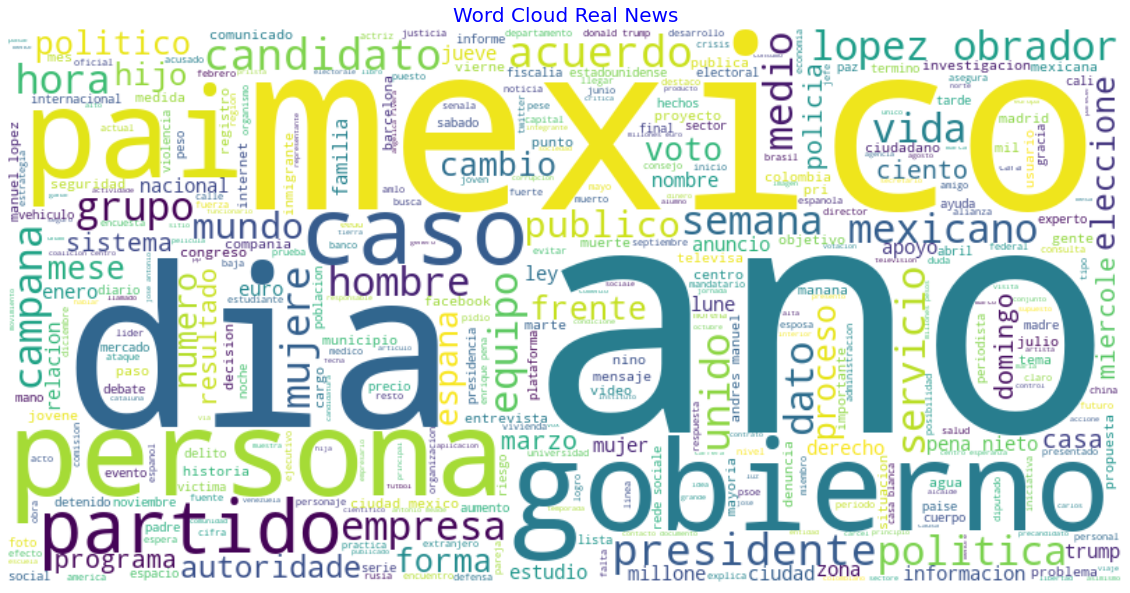

In [ ]:
#Wordcloud 1000 Noticias reales
wc = WordCloud(background_color="white", max_words=3000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(real_news['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Real News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Modelamiento**

## Codificaci√≥n de etiquetas

In [ ]:
category_codes = {
     'Noticia Real': 0,
    'Noticia Falsa': 1
}

In [ ]:
df_merge['Codigo'] = df_merge['Categoria']
df_merge = df_merge.replace({'Codigo':category_codes})

NameError: ignored

In [ ]:
df_base_cp['Codigo'] = df_base_cp['Categoria']
df_base_cp = df_base_cp.replace({'Codigo':category_codes})

## Divisi√≥n de datos

Se realiza el particionamiento de los datos en prueba y validaci√≥n.

In [ ]:
#Division de datos - Corpus propio
X_train_cp, X_test_cp, y_train_cp, y_test_cp = train_test_split(df_base_cp['Processed_Text'], 
                                                    df_base_cp['Codigo'], 
                                                    test_size=0.20, 
                                                    random_state=8)

In [ ]:
#Division de datos - Corpus de referencia + Corpus creado = 1000 noticias
X_train, X_test, y_train, y_test = train_test_split(df_merge['Processed_Text'], 
                                                    df_merge['Codigo'], 
                                                    test_size=0.20, 
                                                    random_state=8)

## **Representaci√≥n del texto**

La representaci√≥n del texto se realiza con sklearn mediante la t√©cnica Tfidf parametrizado con unigramas y bigramas del texto

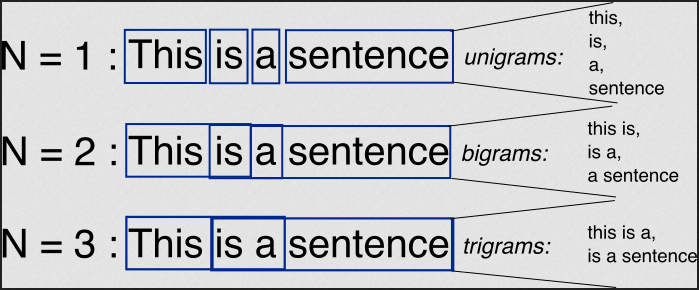

**ngram_range ** tuple (min_n, max_n) default=(1,1): Representa el limite inferior y superior para los n-grams en la extracci√≥n del texto ngram_range=(1,2) representa unigrams y bigrams a aplicarse

**max_df** parametros para ignorar terminos demasiado frecuentes que superan el umbral. ejm: max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".

**min_df** parametros para ignorar terminos no frecuentes y que superen un umbral. ejm: min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".

**max_features:** crea un vocabulario que solo tenga el top max_features ordenadas por frecuencia de t√©rminos en todo el corpus.

fuente: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


In [ ]:
# Eleccion de parametros
ngram_range = (1,3) # unigrams, bigrams, trigrams
min_df = 0.001 # se eliminan los terminos poco frecuentes que aparezcan como minimo en el 0.1% de los documentos
max_df = 0.8 # se eliminan los terminos demaciado frecuentes que aparezcan en almenos el 80% de los documentos (similar a stopwords).
max_features = 300 # 

In [ ]:
# Corpus Propio
features_train_cp,features_test_cp,labels_train_cp,labels_test_cp,tfidf_cp=tifdf_features(X_train_cp, X_test_cp, y_train_cp, y_test_cp,ngram_range,max_df,min_df,max_features)

In [ ]:
# Corpus Mejorado
features_train,features_test,labels_train,labels_test,tfidf=tifdf_features(X_train, X_test, y_train, y_test,ngram_range,max_df,min_df,max_features)

In [ ]:
print(features_train_cp.shape)
print(features_train.shape)

In [ ]:
count_values = features_train.toarray().sum(axis=0)
# list of ngrams
vocab = tfidf.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
df_ngram

## Modelos de clasificaci√≥n

Metricas de evaluaci√≥n

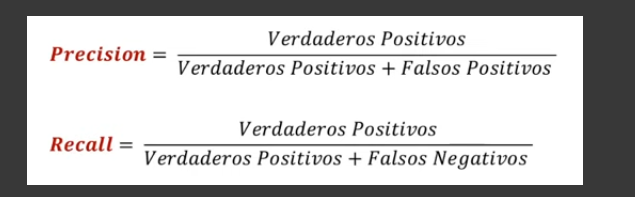

### **RandomForestClassifier**


In [ ]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
hyperparameters_tuning = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(hyperparameters_tuning)

#### **RandomForest Classifier - Corpus del proyecto**

In [ ]:
%%time
# First create the base model to tune
rfc = RandomForestClassifier(random_state=rng)

# Definition of the random search
random_search_cp = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=hyperparameters_tuning,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=rng)

# Fit the random search model
random_search_cp.fit(features_train_cp, labels_train_cp)
print("Mejores hiperparametros:",random_search_cp.best_params_)
print("Accuracy hiperparametros:",random_search_cp.best_score_)

In [ ]:
# se entrena el modelo con los parametros encontrados en la busqueda aleatoria.
clf_cp = RandomForestClassifier(n_estimators=1000, min_samples_split=2,min_samples_leaf=2, max_features='auto', max_depth=None, bootstrap=True)
clf_cp.fit(features_train_cp, labels_train_cp)
clf_predict_cp = clf_cp.predict(features_test_cp)

In [ ]:
# Matrix de confunsi√≥n 500 noticias
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, clf_predict_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
accuracy_randomforest_cp=accuracy_score(labels_test_cp, clf_predict_cp)
print("Accuracy Corpus propio",accuracy_randomforest_cp)

In [ ]:
clf_predict_proba_cp = clf_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, clf_predict_proba_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,clf_predict_proba_cp)

#### **RandomForest Classifier - Corpus Mejorado**

In [ ]:
%%time
# First create the base model to tune
rfc = RandomForestClassifier(random_state=rng)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=hyperparameters_tuning,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=rng)

# Fit the random search model
random_search.fit(features_train, labels_train)
print("Mejores hiperparametros:",random_search.best_params_)
print("Accuracy hiperparametros:",random_search.best_score_)

In [ ]:
# se entrena el modelo con los parametros encontrados en la busqueda aleatoria.
clf = RandomForestClassifier(n_estimators=1000, min_samples_split=2,min_samples_leaf=1, max_features='auto', max_depth=80, bootstrap=True)
clf.fit(features_train, labels_train)
clf_predict = clf.predict(features_test)

In [ ]:
# Matrix de confunsi√≥n 1000 noticias
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, clf_predict)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
accuracy_randomforest=accuracy_score(labels_test, clf_predict)
print(accuracy_randomforest)

In [ ]:
clf_predict_proba = clf.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, clf_predict_proba)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,clf_predict_proba)

## **Naive Bayes**

### **Naive Bayes Corpus del proyecto**

In [ ]:
%%time
hyperparameters_tuning ={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),'fit_prior' : [True, False]}
best_model_nb_cp,predictions_nb_cp,accuracy_nb_cp=randomsearchmodels(MultinomialNB(),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

In [ ]:
MultinomialNB().get_params().keys()

In [ ]:
print("Naive Bayes Accuracy Score -> ",accuracy_nb_cp)
print("Mejores hiperparametros NB:",best_model_nb_cp.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_nb_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
predict_nb_cp=best_model_nb_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, predict_nb_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,predict_nb_cp)

### **Naive Bayes Corpus Mejorado**

In [ ]:
%%time
hyperparameters_tuning ={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),'fit_prior' : [True, False]}
best_model_nb,predictions_nb,accuracy_nb=randomsearchmodels(MultinomialNB(),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

In [ ]:
print("Naive Bayes Accuracy Score -> ",accuracy_nb)
print("Mejores hiperparametros NB:",best_model_nb.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_nb)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
predict_nb=best_model_nb.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, predict_nb)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,predict_nb)

## **SVC**

### **SVC Corpus del proyecto**

In [ ]:
%%time
hyperparameters_tuning = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf','sigmoid']}
best_model_svc_cp,predictions_svc_cp,accuracy_svc_cp=randomsearchmodels(SVC(probability=True),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

In [ ]:
print("SVM Accuracy Score -> ",accuracy_svc_cp)
print("Mejores hiperparametros SVM:",best_model_svc_cp.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_svc_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
predict_svc_cp=best_model_svc_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, predict_svc_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,predict_svc_cp)

### **SVC Corpus Mejorado**

In [ ]:
%%time
hyperparameters_tuning = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf','sigmoid']}
best_model_svc,predictions_svc,accuracy_svc=randomsearchmodels(SVC(probability=True),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)                                       

In [ ]:
print("SVM Accuracy Score -> ",accuracy_svc)
print("Mejores hiperparametros SVM:",best_model_svc.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_svc)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
predict_svc=best_model_svc.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, predict_svc)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,predict_svc)

## **Logistic Regression**

### **Logistic Regression Corpus del proyecto**

In [ ]:
%%time
hyperparameters_tuning = {'C':np.logspace(-2,1,100),'penalty':['l2']}
#hyperparameters_tuning = {'C':np.logspace(-2,1,100),'solver': ['newton-cg', 'lbfgs', 'liblinear'],'penalty': ['none', 'l2']}
best_model_logistic_cp,predictions_logistic_cp,accuracy_logistic_cp=randomsearchmodels(LogisticRegression(class_weight='balanced'),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

In [ ]:
print("Logistic Regression Accuracy Score -> ",accuracy_logistic_cp)
print("Mejores hiperparametros LR:",best_model_logistic_cp.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_logistic_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
y_pred_proba_cp= best_model_logistic_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp,y_pred_proba_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,y_pred_proba_cp)

### **Logistic Regression Corpus Mejorado**

In [ ]:
%%time
hyperparameters_tuning = {'C':np.logspace(-2,1,100),'penalty':['l2']}
#hyperparameters_tuning = {'C':np.logspace(-2,1,100),'solver': ['newton-cg', 'lbfgs', 'liblinear'],'penalty': ['none', 'l2']}
best_model_logistic,predictions_logistic,accuracy_logistic=randomsearchmodels(LogisticRegression(class_weight='balanced'),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

In [ ]:
print("Logistic Regression Accuracy Score -> ",accuracy_logistic)
print("Mejores hiperparametros LR:",best_model_logistic.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_logistic)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
y_pred_proba= best_model_logistic.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test,y_pred_proba)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,y_pred_proba)

## **XGBoost**

### **XGBoost Corpus del proyecto**

In [ ]:
%%time
hyperparameters_tuning={'colsample_bytree' : [0.3, 0.5, 1.0],'gamma' : [0.1, 1, 1.5],'learning_rate' : [0.1, 0.01, 0.05,0.9],'min_child_weight' : [1, 5, 10],'scale_pos_weight' : [1, 2, 4],'subsample' : [0.8, 0.9, 1.0],'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],'max_depth' : [3,5,7,9],'reg_alpha':[0.1, 0.01, 0.05],'eta_vals': [0.001, 0.01, 0.1]}
best_model_xgb_cp,predictions_xgb_cp,accuracy_xgb_cp=randomsearchmodels(xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

In [ ]:
print("XGBoost Accuracy Score: ",accuracy_xgb_cp)
print("Mejores hiperparametros XG:",best_model_xgb_cp.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_xgb_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
y_pred_proba_cp= best_model_xgb_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp,y_pred_proba_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,y_pred_proba_cp)

### **XGBoost Corpus Mejorado**

In [ ]:
%%time
hyperparameters_tuning={'colsample_bytree' : [0.3, 0.5, 1.0],'gamma' : [0.1, 1, 1.5],'learning_rate' : [0.1, 0.01, 0.05,0.9],'min_child_weight' : [1, 5, 10],'scale_pos_weight' : [1, 2, 4],'subsample' : [0.8, 0.9, 1.0],'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],'max_depth' : [3,5,7,9],'reg_alpha':[0.1, 0.01, 0.05],'eta_vals': [0.001, 0.01, 0.1]}
best_model_xgb,predictions_xgb,accuracy_xgb=randomsearchmodels(xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

In [ ]:
print("XGBoost Accuracy Score: ",accuracy_xgb)
print("Mejores hiperparametros XG:",best_model_xgb.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_xgb)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
y_pred_proba= best_model_xgb.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test,y_pred_proba)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,y_pred_proba)

## **Redes Neuronales**

### **Red Neuronal Corpus del proyecto**

In [ ]:
# create model
#features_train_cp.shape[1] representa el numero de columnas de los datos de entrenamiento.
tf.keras.backend.clear_session()
model = Sequential()
model.add(Dense(12, input_dim=features_train_cp.shape[1], activation='relu'))
model.add(Dense(128 , activation='relu' ))
model.add(Dense(64 , activation='relu' ))
model.add(Dense(64 , activation='relu' ))
model.add(Dense(32 , activation='relu' ))
model.add(Dense(32 , activation='relu' ))
model.add(Dense(8 , activation='relu' ))
model.add(Dense(1 , activation='sigmoid' ))

In [ ]:
# Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

In [ ]:
print(features_train_cp.shape)
print(features_test_cp.shape)
print(type(features_train_cp))
print(type(labels_test_cp))
print((features_train_cp.shape[1]))

In [ ]:
dataxTrain=features_train_cp[100:,:]
datayTrain=labels_train_cp[100:]

DataxVal=features_train_cp[:100,:]
DatayVal=labels_train_cp[:100]

print(dataxTrain.shape)
print(datayTrain.shape)
print(DataxVal.shape)
print(DatayVal.shape)

In [ ]:
X_train_nn_cp=dataxTrain.toarray()
y_train_nn_cp=datayTrain.to_numpy()
X_val_nn_cp=DataxVal.toarray()
y_val_nn_cp=DatayVal.to_numpy()  

In [ ]:
print(X_train_nn_cp.shape)
print(y_train_nn_cp.shape)
print(X_val_nn_cp.shape)
print(y_val_nn_cp.shape)

In [ ]:
%%time
#¬†Fit¬†the¬†model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40)
entrenamiento=model.fit(x= X_train_nn_cp, 
                        y=y_train_nn_cp,
                        validation_data=(X_val_nn_cp,
                                         y_val_nn_cp),
                        batch_size=32,
                        callbacks=[callback],
                        epochs=200,
                        verbose=1)

In [ ]:
#X_train_cp, X_test_cp, y_train_cp, y_test_cp 
loss, accuracy = model.evaluate(features_test_cp.toarray(), labels_test_cp.to_numpy())

In [ ]:
prediccion=model.predict(features_test_cp)

In [ ]:
y_predict=(prediccion>0.5)
confusion_matrix(labels_test_cp,y_predict)

In [ ]:
print(labels_test_cp.shape)
print(labels_test_cp.shape)

In [ ]:
accuracy_nn_cp=max(entrenamiento.history['val_accuracy'])

In [ ]:
## grafica de la evoluci√≥n de la funcion de perdida
def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  plt.figure(figsize=(10,5))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_accuracy'], label="Val Error")
  #plt.plot(hist['epoch'], hist['mae'], label='MAE')
  #plt.plot(hist['epoch'], hist['val_mae'], label='val MAE')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(entrenamiento)

In [ ]:
## grafica de la evoluci√≥n de la funcion de perdida
def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  plt.figure(figsize=(10,5))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['loss'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'], label="Val Error")
  #plt.plot(hist['epoch'], hist['mae'], label='MAE')
  #plt.plot(hist['epoch'], hist['val_mae'], label='val MAE')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(entrenamiento)

### **Red Neuronal Corpus mejorado**

In [ ]:
DataxVal# create model
#features_train_cp.shape[1] representa el numero de columnas de los datos de entrenamiento.
tf.keras.backend.clear_session()
model = Sequential()
model.add(Dense(12, input_dim=features_train.shape[1], activation='relu'))
model.add(Dense(128 , activation='relu' ))
model.add(Dense(64 , activation='relu' ))
model.add(Dense(64 , activation='relu' ))
model.add(Dense(32 , activation='relu' ))
model.add(Dense(32 , activation='relu' ))
model.add(Dense(8 , activation='relu' ))
model.add(Dense(1 , activation='sigmoid' ))

In [ ]:
# Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

In [ ]:
DataxVal=features_train[:529,:]
DatayVal=labels_train[:529]

dataxTrain=features_train[529:,:]
datayTrain=labels_train[529:]

print(dataxTrain.shape)
print(datayTrain.shape)
print(DataxVal.shape)
print(DatayVal.shape)

In [ ]:
X_train_nn_cp=dataxTrain.toarray()
y_train_nn_cp=datayTrain.to_numpy()
X_val_nn_cp=DataxVal.toarray()
y_val_nn_cp=DatayVal.to_numpy()  

In [ ]:
print(X_train_nn_cp.shape)
print(y_train_nn_cp.shape)
print(X_val_nn_cp.shape)
print(y_val_nn_cp.shape)

In [ ]:
%%time
#¬†Fit¬†the¬†model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40)
entrenamiento=model.fit(x= X_train_nn_cp, 
                        y=y_train_nn_cp,
                        validation_data=(X_val_nn_cp,
                                         y_val_nn_cp),
                        batch_size=32,
                        callbacks=[callback],
                        epochs=200,
                        verbose=1)

In [ ]:

loss, accuracy = model.evaluate(features_test.toarray(), labels_test.to_numpy())

In [ ]:
prediccion=model.predict(features_test)

In [ ]:
y_predict=(prediccion>0.5)
confusion_matrix(labels_test,y_predict)

In [ ]:
print(features_test.shape)
print(labels_test.shape)

In [ ]:
accuracy_nn_cp=max(entrenamiento.history['val_accuracy'])

In [ ]:
## grafica de la evoluci√≥n de la funcion de perdida
def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  plt.figure(figsize=(10,5))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_accuracy'], label="Val Error")
  #plt.plot(hist['epoch'], hist['mae'], label='MAE')
  #plt.plot(hist['epoch'], hist['val_mae'], label='val MAE')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(entrenamiento)

# **BERT**

###BERT Con corpus preprocesado propio



In [ ]:
# alistamiento de los datos para el entrenamiento con BERT
noticias_falsas=df_base_cp[df_base_cp['Categoria']=='Noticia Falsa']
noticias_verdaderas=df_base_cp[df_base_cp['Categoria']=='Noticia Real']

In [ ]:
new_dataframe_suffle_true=noticias_verdaderas.sample(frac=1)
new_dataframe_suffle_false=noticias_falsas.sample(frac=1)

In [ ]:
new_dataframe_suffle_true

Categoria                                              Texto  \
290  Noticia Real   Expectativa por protagonismo femenino en elec...   
24   Noticia Real  La¬†Procuradur√≠a¬†revel√≥ que despu√©s de revisar ...   
396  Noticia Real  Vulnerabilidad al cambio clim√°tico del sector ...   
100  Noticia Real  La Polic√≠a Nacional espa√±ola detuvo a un colom...   
358  Noticia Real  √ìscar Iv√°n Zuluaga da positivo a covid-20\nEl ...   
..            ...                                                ...   
375  Noticia Real   Aumento de penas y otros cambios de nueva Ley...   
109  Noticia Real  Unos hombres que vest√≠an prendas alusivas a la...   
457  Noticia Real  Este mi√©rcoles, 26 de enero, se conoci√≥ que la...   
629  Noticia Real  Consejo Nacional Electoral pide auditor√≠a de s...   
578  Noticia Real  \nEn la noche del pasado domingo 20 de marzo, ...   

                                        Processed_Text  Codigo  
290  expectativa protagonismo femenino eleccione ll...       0  
24   procuraduria revelo revisar antecedente candid...       0  
396  vulnerabilidad cambio climatico sector empresa...       0  
100  policia nacional espanola detuvo colombiano ma...       0  
358  oscar ivan zuluaga positivo covid candidato ce...       0  
..                                                 ...     ...  
375  aumento penas cambios ley seguridad ciudadana ...       0  
109  hombres vestian prendas alusivas policia nacio...       0  
457  miercole enero conocio procuraduria regional v...       0  
629  consejo nacional electoral pide auditoria soft...       0  
578  noche domingo marzo grupo jovenes barrio ciuda...       0  

[317 rows x 4 columns]

In [ ]:
new_dataframe_suffle_false

Categoria                                              Texto  \
510  Noticia Falsa  LUTO NACIONAL Acaba de ocurrir un terrible acc...   
555  Noticia Falsa  GOBIERNO DE EEUU SANCIONA A SANTOS POR ESTA ES...   
228  Noticia Falsa  No est√°s obligado a vacunarte \nAcuerdo de N√∫r...   
207  Noticia Falsa  LA TRISTE HISTORIA DEL BLACK FRIDAY  Durante e...   
310  Noticia Falsa  5 empleados del Ara en coma, 4 polic√≠as muerto...   
..             ...                                                ...   
71   Noticia Falsa  ATENCI√ìN.\n\nLa Pandemia, bajo la √≥ptica de Ma...   
196  Noticia Falsa  el Alto Comisionado para la Paz, Miguel Ceball...   
80   Noticia Falsa  Un ojo vale m√°s que una protesta. Mi consejo e...   
161  Noticia Falsa  Timochenko confirma regreso de Iv√°n M√°rquez al...   
536  Noticia Falsa  La riqueza es de quien la necesita, no de quie...   

                                        Processed_Text  Codigo  
510  luto nacional acaba ocurrir terrible accidente...       1  
555  gobierno eeuu sanciona santos escandalosa noti...       1  
228  obligado vacunarte acuerdo nuremberg obligar v...       1  
207  triste historia black friday comercio esclavos...       1  
310  empleados ara coma policias muertos uniformado...       1  
..                                                 ...     ...  
71   atencion pandemia optica manuel elkin patarrol...       1  
196  alto comisionado paz miguel ceballos evaluacio...       1  
80   ojo vale protesta consejo salgan marchar novie...       1  
161  timochenko confirma regreso ivan marquez narco...       1  
536  riqueza necesita crea frase carrera apareciero...       1  

[317 rows x 4 columns]

In [ ]:
print(new_dataframe_suffle_true.shape)
print(new_dataframe_suffle_false.shape)

(317, 4)
(317, 4)


In [ ]:
test_true=new_dataframe_suffle_true.iloc[:60,:]
test_false=new_dataframe_suffle_false.iloc[:60,:]
training_true=new_dataframe_suffle_true.iloc[60:,:]
training_false=new_dataframe_suffle_false.iloc[60:,:]
print(test_true.shape)
print(test_false.shape)
print(training_true.shape)
print(training_false.shape)

(60, 4)
(60, 4)
(257, 4)
(257, 4)


In [ ]:
test_true

Categoria                                              Texto  \
290  Noticia Real   Expectativa por protagonismo femenino en elec...   
24   Noticia Real  La¬†Procuradur√≠a¬†revel√≥ que despu√©s de revisar ...   
396  Noticia Real  Vulnerabilidad al cambio clim√°tico del sector ...   
100  Noticia Real  La Polic√≠a Nacional espa√±ola detuvo a un colom...   
358  Noticia Real  √ìscar Iv√°n Zuluaga da positivo a covid-20\nEl ...   
458  Noticia Real  \nEl secretario de Seguridad de Cali, Carlos J...   
40   Noticia Real  La decisi√≥n la confirm√≥ la representante legal...   
255  Noticia Real  Partidos y coaliciones inician presentaci√≥n de...   
339  Noticia Real  Lo √∫ltimo: Diego Cadena, suspendido 3 a√±os par...   
347  Noticia Real  Comienza inscripci√≥n de candidatos a la presid...   
143  Noticia Real  \nEste martes, 14 de diciembre de 2021, el cor...   
346  Noticia Real   Logramos regular el uso de las armas traum√°ti...   
367  Noticia Real  Fuad Char hace campa√±a en La Mojana sucre√±a\nL...   
606  Noticia Real  Preocupaci√≥n por aumento de ri√±as en los plant...   
8    Noticia Real  Canciller propone a Cuba agenda de mutua confi...   
481  Noticia Real  El senador Roy Barreras, quien aspira nuevamen...   
483  Noticia Real  Colombia est√° a cuatro meses de votar en las u...   
447  Noticia Real  Comunidad aleda√±a a la carrilera del tren en C...   
21   Noticia Real  Al entrar en la recta final de su mandato, el ...   
378  Noticia Real   Claudia L√≥pez descarta la propuesta de 'pico ...   
110  Noticia Real  El Ej√©rcito Nacional inform√≥ que fue dado de b...   
253  Noticia Real  La carta donde el candidato del Centro Democr√°...   
585  Noticia Real  \nLas alianzas pol√≠ticas cobran fuerza en el p...   
20   Noticia Real  A las 6:00 p.m. se cerr√≥ el plazo para la insc...   
91   Noticia Real  Innovaci√≥n en el manejo del trauma: Esternotom...   
365  Noticia Real  Germ√°n Var√≥n se adhiere a la campa√±a de Alejan...   
10   Noticia Real  Cadena perpetua para los corruptos: Gilberto T...   
372  Noticia Real   Dian y Dane llegan a nuevo acuerdo de acceso ...   
127  Noticia Real  \nEn las √∫ltimas horas, las autoridades han in...   
96   Noticia Real  Un ataque sicarial en zona rural de Buenos Air...   
610  Noticia Real  Autoridades intensifican medidas preventivas c...   
356  Noticia Real  Conservadores proclamaron a David Barguil como...   
580  Noticia Real  \nLuego de que la Registradur√≠a Nacional y el ...   
619  Noticia Real  Elecciones 2022: los municipios que m√°s partic...   
130  Noticia Real  Por medio de un video revelado por Blu Radio, ...   
120  Noticia Real  \nUn hombre fue capturado en el momento en que...   
462  Noticia Real  \nLa Organizaci√≥n Tejido de Defensa de la Vida...   
271  Noticia Real   As√≠ podr√° acceder a los incentivos por genera...   
376  Noticia Real   Debate presidencial: qu√© dijeron los candidat...   
123  Noticia Real  \nDurante los operativos realizados por la Pol...   
2    Noticia Real  Marta Luc√≠a Ram√≠rez se queja por servicio en e...   
264  Noticia Real  CNE estudia revocar candidatura de Jorge Tovar...   
112  Noticia Real  \nEn la tarde del s√°bado 15 de enero, se prese...   
604  Noticia Real  Se cumplen 20 a√±os del magnicidio de Monse√±or ...   
295  Noticia Real   Investigar√°n a Claudia L√≥pez por participaci√≥...   
31   Noticia Real  El pastor cristiano Alfredo Saade decidi√≥ apar...   
97   Noticia Real  El Centro Cibern√©tico de la Dij√≠n inform√≥ que ...   
92   Noticia Real  El mundo atraviesa por un momento decisivo en ...   
449  Noticia Real  \nGracias a la acci√≥n conjunta del Cuerpo T√©cn...   
380  Noticia Real   As√≠ ser√° el primer debate entre 10 aspirantes...   
146  Noticia Real  Este lunes, 13 de diciembre, en presencia del ...   
594  Noticia Real  Ordenan habilitar vacunaci√≥n durante eleccione...   
364  Noticia Real  Cristianos coquetean con el Equipo por Colombi...   
292  Noticia Real   Registradur√≠a adquiri√≥ software de escrut

In [ ]:
test_true=test_true.reset_index(drop=True)
test_false=test_false.reset_index(drop=True)

In [ ]:
training_false.Texto.iloc[200]

'Al fin se destapa. ¬°Extraordinario! Polonia, Suecia y Noruega est√°n presentando una demanda contra la OMS por infectar a Europa. Los pilotos detenidos han admitido rociar un producto qu√≠mico que causa neumonitis qu√≠mica'

In [ ]:
# reset de los indices
#noticias_falsas=noticias_falsas.reset_index(drop=True)
#noticias_verdaderas=noticias_verdaderas.reset_index(drop=True)
len_noticias_falsas=len(training_false)
len_noticias_verdaderas=len(training_true)
len_noticias_falsas_test=len(test_false)
len_noticias_verdaderas_test=len(test_true)

In [ ]:
training_false=training_false.reset_index(drop=True)
training_true=training_true.reset_index(drop=True)

In [ ]:
test_false=test_false.reset_index(drop=True)
test_true=test_true.reset_index(drop=True)

In [ ]:
## ver el directorio actual de trabajo
import os
print(os.getcwd())
#os.chdir(os.getcwd())

/content


In [ ]:
# crear  los directorios y separar las noticias de manera individual
os.makedirs('news')
os.chdir('news')
os.makedirs('train')
os.chdir('train')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_falsas), range(len_noticias_falsas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_false['Processed_Text'][i])

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('train')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas), range(len_noticias_verdaderas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_true['Processed_Text'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.makedirs('test')
os.chdir('test')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_false['Processed_Text'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('test')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_true['Processed_Text'][i])
os.chdir('/content')

In [ ]:
# para borra los directorios
import shutil
os.chdir('/content')
#os.chdir('news')

shutil.rmtree('news')

In [ ]:
## se leen las noticias utilizando las utilidades de keras
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'news/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 514 files belonging to 2 classes.
Using 412 files for training.
Found 514 files belonging to 2 classes.
Using 102 files for validation.
Found 120 files belonging to 2 classes.


In [ ]:
# se define la arquitectura de la red neuronal utilizando a BERT para que haga parte del modelo (Fine Tunning)
tf.keras.backend.clear_session()
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

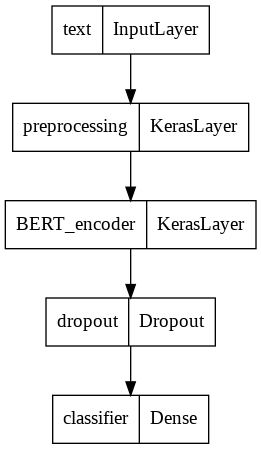

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
# definici√≥n de la funcion de perdida y la metrica a utilizar
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# parametrizaci√≥n
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compilaci√≥n del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
## entrenamiento del modelo con todas la noticias.
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/5
13/13 [==============================] - 55s 2s/step - loss: 0.6185 - binary_accuracy: 0.6408 - val_loss: 0.3140 - val_binary_accuracy: 0.8922
Epoch 2/5
13/13 [==============================] - 27s 2s/step - loss: 0.2874 - binary_accuracy: 0.8738 - val_loss: 0.3773 - val_binary_accuracy: 0.8824
Epoch 3/5
13/13 [==============================] - 27s 2s/step - loss: 0.1927 - binary_accuracy: 0.9393 - val_loss: 0.1685 - val_binary_accuracy: 0.9510
Epoch 4/5
13/13 [==============================] - 27s 2s/step - loss: 0.1274 - binary_accuracy: 0.9539 - val_loss: 0.2801 - val_binary_accuracy: 0.9020
Epoch 5/5
13/13 [==============================] - 27s 2s/step - loss: 0.0803 - binary_accuracy: 0.9733 - val_loss: 0.1744 - val_binary_accuracy: 0.9412
CPU times: user 1min 43s, sys: 26.2 s, total: 2min 10s
Wall time: 3min 9s


In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


4/4 [==============================] - 3s 624ms/step - loss: 0.4287 - binary_accuracy: 0.8833
Loss: 0.4286675751209259
Accuracy: 0.8833333253860474


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


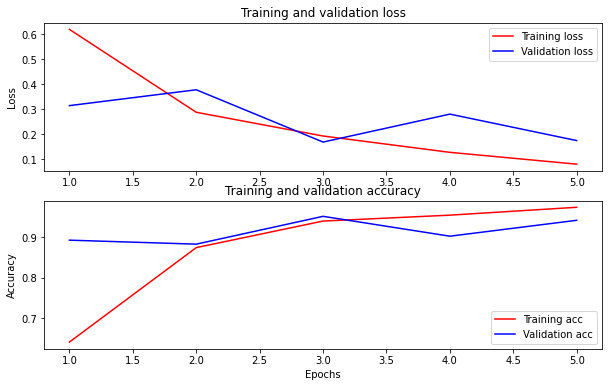

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'noticias'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

In [ ]:
os.getcwd()

'/content'

In [ ]:
classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./noticias_bert/assets


INFO:tensorflow:Assets written to: ./noticias_bert/assets


In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def pruebasPrediccion(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

In [ ]:
examples = [
    'Decretan calamidad p√∫blica por ola invernal en Cundinamarca', 
    'Tasas de inter√©s podr√≠an ubicarse en el 6%, para finales de abril',
    'Con el hundimiento del proyecto de reforma al C√≥digo Electoral en la Corte Constitucional, por considerar que se presentaron vicios de tr√°mite en el Congreso, no solamente se pierden dos a√±os de trabajo que se invirtieron en este tema, sino que los ajustes que conten√≠a podr√≠an quedarse, ahora en una nueva iniciativa, para ser aplicados hasta las elecciones presidenciales de 2026.',
    'Fallece presidente Donal trump abatido por sicarios sirios. Tenemos las primeras imagenes del cuerpo',
    'Posibles narcotraficantes est√°n financiando campa√±a a la presidencia de Federico Guti√©rrez.El caso que implica a Federico Guti√©rrez y otros funcionarios lo anunci√≥ la Procuradur√≠a General',
    'En una entrevista reciente, se le pregunt√≥ al candidata Gustavo Perro: ¬øCree que hay un Dios? Su respuesta fue :  Mi sistema de creencias no apoya a un creador como tal" Dios fue una figura imaginaria creada por el hombre. ¬øAlguien lo ha visto? Si alguien tiene pruebas concretas de su existencia, lo desafio a que me las muestre. Lo que tenemos son simplemente teor√≠as inventadas por el hombre. La gente vive enga√±ada pensando que Dios nos creo y no es as√≠. El candidato Gustavo Peto concluyo: Entonces, si usted me pregunta si existe un Diesel creo en un Dios humana y no sobrehumano.y lo creo, es porque creo que yo soy Dios.',
    'En una iglesia ucraniana que qued√≥ totalmente destruida, solo qued√≥ intacta la imagen de Cristo resucitado. Si esto no son signos de los tiempos, entonces ¬øQu√© es? Esta imagen de Cristo nos lo recuerda, resucitando de los escombros, como signo de esperanza. Podr√°n destruir templos, pero la fe jam√°s. Cristo nos repite Yo soy la resurrecci√≥n y la vida',
    'Vendedores del Palacio del Colesterol viven con el temor a que desaparezca',
    'A comienzos de este mes reabri√≥ sus puertas, tras dos a√±os de quiebra y desolaci√≥n, la popular plazoleta de comidas ubicada a las espaldas de El Camp√≠n y que, durante las √∫ltimas seis d√©cadas, se convirti√≥ en un refugio c√°lido para que los hinchas del f√∫tbol, tras el √∫ltimo pitazo de un partido, tuvieran un lugar en el que pudieran seguir hablando de un tema: f√∫tbol, por supuesto.',
    'las palomas tienen m√°s prote√≠nas, en Suecia comen palomas, comiendo palomas no sacrifican tantos pollos Fenavi paraco',
    'Q tristeza q tengan q pagar gente inocente, y solo buscan culpables y dicen que es petro a medrantando ala gente es mentira es el gobierno de uribe q casualidad q para elecciones pasen tantas cosas, y si ganan los uribistas nu hay terrorismo',
    'el candidato @FicoGutierrez dice que subir√≠a los impuestos a las motos adem√°s de poner peajes urbanos y pico y placa todo el d√≠a en el pa√≠s para mejorar la seguridad',
    'Posibles narcotraficantes est√°n financiando campa√±a a la presidencia de Federico Guti√©rrez',
    '¬øAhora entienden por qu√© solo aparecen votos para favorecer al terrorista indultado? Este tipo es el √∫nico que puede a Fico con fraude y por eso debe ser destituido de su cargo antes de las presidenciales',
    'Y con ustedes desde las filas de las Farc, la narco terrorista',
    'Si Usted depende para VIVIR del Arriendo de un Apartamentico o Casa que Compro con el Trabajo de A√±os, Valla Olvidandose por que Petro el ( Ch√°vez Colombiano) se la va a Expropiar',
    'Las iglesias evang√©licas en Colombia, deber√≠an tener control y l√≠mites, adem√°s deber√≠an pagar impuestos como cualquier empresa (sic)',
    'Los coste√±os son la poblaci√≥n menos intelectual del pa√≠s , es por eso que esta regi√≥n de Colombia est√° sumida en la pobreza. Tampoco les gusta trabajar por eso hay en estos momentos hay un nivel muy alto de miseria en la guajira . Con el centro democr√°tico cambiaremos (sic)',
    'Esta es la verdadera raz√≥n C del fallo sobre el aborto. Le lavan los cr√≠menes a los amigos ideol√≥gicos de las FARC. Rosa blanca denunci√≥ a las FARC ante la CPI por los abortos obligados a ni√±as reclutadas. Pero con ese fallo de la CConstitucional, el delito de las FARC desaparece. Entienden? Por eso la declaraci√≥n de Andr√©s Pastrana . El fallo de la corte es un fallo pol√≠tico.',
    '50 mil camioneros han empezado a rodear el parlamento canadiense en Ottawa y tienen la consigna de no moverse hasta acabar con el pasaporte sanitario y poner de rodillas a Trudeau hasta lograr su dimisi√≥n',
    'Ministerio de Nacional de Defensa China, Tan Kefei, anunci√≥ que en cualquier momento, y en cualquier lugar est√°n dispuestos a apoyar a Rusia en caso de que EE.UU y la OTAN quieran intervenir üòñü§î‚Ä¶ AH PERO FUERON TODOS A LAS OLIMPIADAS A CELEBRARLE EL VIRUS Y MUERTES',
    'LUTO NACIONAL Acaba de ocurrir un terrible accidente a√©reo de un avi√≥n de pasajeros. No hubo sobrevivientes. Un conductor grab√≥ el video desde su auto',
    'en plenaria del senado intentar√°n quitarle la pensi√≥n a las esposas de los que fallecen y a los hijos especiales',
    'Argentina: La ANMAT reconoce que las vacunas contienen grafeno,',
    'Se anul√≥ la vacunaci√≥n universal. Una gran victoria para la libertad, la Corte Suprema anul√≥ la vacunaci√≥n universal',
    'Recuerdan lo de las 10 millones de firmas para rebajar los sueldos de los congresistas? Esas firmas fueron aprobadas y fue aprobada tambi√©n la consulta. Ahora nos corresponde a nosotros votar este 11 de marzo para que se haga efectiva y sea aprobada y llegue al congreso sin modificaciones',
    'A comienzos de este mes reabri√≥ sus puertas, tras dos a√±os de quiebra y desolaci√≥n, la popular plazoleta de comidas ubicada a las espaldas de El Camp√≠n',
    'La Fiscal√≠a inform√≥ este lunes que pidi√≥ el retiro del preacuerdo al que lleg√≥ con Jhonier Leal, por el doble homicidio de su hermano, el estilista Mauricio Leal, y su madre Marleni Hern√°ndez.',
    'La Fiscal√≠a inform√≥ este lunes que pidi√≥ el retiro del preacuerdo al que lleg√≥ con Jhonier Leal, por el doble homicidio de su hermano, el estilista Mauricio Leal, y su madre Marleni Hern√°ndez. Todo se debe a las declaraciones del acusado la semana pasada, al retractarse de aceptar los cargos al denunciar una supuesta presi√≥n por parte del ente acusador, para que firmara el preacuerdo.',
    'El candidato presidencial Luis P√©rez neg√≥ las acusaciones que hizo el excabecilla del Clan del Golfo, alias Otoniel, donde se√±al√≥ que ten√≠a nexos con paramilitares, en concreto con alias Mi Sangre, un  narcotraficante, considerado como uno de los capos de la Oficina de Envigado.'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
print('Results from the saved model:')
pruebasPrediccion(examples, reloaded_results)

Results from the saved model:
input: Decretan calamidad p√∫blica por ola invernal en Cundinamarca : score: 0.007332
input: Tasas de inter√©s podr√≠an ubicarse en el 6%, para finales de abril : score: 0.083372
input: Con el hundimiento del proyecto de reforma al C√≥digo Electoral en la Corte Constitucional, por considerar que se presentaron vicios de tr√°mite en el Congreso, no solamente se pierden dos a√±os de trabajo que se invirtieron en este tema, sino que los ajustes que conten√≠a podr√≠an quedarse, ahora en una nueva iniciativa, para ser aplicados hasta las elecciones presidenciales de 2026. : score: 0.477488
input: Fallece presidente Donal trump abatido por sicarios sirios. Tenemos las primeras imagenes del cuerpo : score: 0.019615
input: Posibles narcotraficantes est√°n financiando campa√±a a la presidencia de Federico Guti√©rrez.El caso que implica a Federico Guti√©rrez y otros funcionarios lo anunci√≥ la Procuradur√≠a General : score: 0.327614
input: En una entrevista reciente

###BERT Con corpus preprocesado unido



In [ ]:
# alistamiento de los datos para el entrenamiento con BERT
noticias_falsas=df_merge[df_merge['Categoria']=='Noticia Falsa']
noticias_verdaderas=df_merge[df_merge['Categoria']=='Noticia Real']

In [ ]:
new_dataframe_suffle_true=noticias_verdaderas.sample(frac=1)
new_dataframe_suffle_false=noticias_falsas.sample(frac=1)

In [ ]:
new_dataframe_suffle_true

Unnamed: 0     Categoria  \
1234         600  Noticia Real   
345          345  Noticia Real   
2544        1234  Noticia Real   
2628        1318  Noticia Real   
3250        1940  Noticia Real   
...          ...           ...   
2651        1341  Noticia Real   
2505        1195  Noticia Real   
1296         662  Noticia Real   
1275         641  Noticia Real   
3213        1903  Noticia Real   

                                                  Texto  \
1234  Karla Souza rompe el silencio en sus redes soc...   
345    Precandidatos aceleran desarrollo de campa√±as...   
2544  La s√≠ndica de Unides Podem en Les Corts Valenc...   
2628  Los barones chocan con Pablo Casado por negarl...   
3250  La Intervenci√≥n de la Generalitat tambi√©n cues...   
...                                                 ...   
2651  Los mejores momentos del desfile de Victoria's...   
2505  La Polic√≠a Nacional de Ceuta ha detenido en la...   
1296  CHICHARITO 'ENCIENDE' EL INSTAGRAM DE YUYA\nEl...   
1275  Fernando Colunga reaparece tras un largo perio...   
3213   Ciudad Real, Campo de Criptana y Calzada de C...   

                                         Processed_Text  
1234  karla souza rompe silencio rede sociale testim...  
345   precandidatos aceleran desarrollo campanas pai...  
2544  sindica unides podem corts valencianes naiara ...  
2628   barones chocan pablo casado negarles giro centro  
3250  intervencion generalitat cuestiona informe aud...  
...                                                 ...  
2651  mejore momentos desfile victoria secret shangh...  
2505  policia nacional ceuta detenido horas personas...  
1296  chicharito enciende instagram yuya atacante me...  
1275  fernando colunga reaparece periodo ausente luc...  
3213  ciudad real campo criptana calzada calatrava m...  

[1655 rows x 4 columns]

In [ ]:
new_dataframe_suffle_false

Unnamed: 0      Categoria  \
221          221  Noticia Falsa   
3174        1864  Noticia Falsa   
2358        1048  Noticia Falsa   
1757         447  Noticia Falsa   
2530        1220  Noticia Falsa   
...          ...            ...   
1049         415  Noticia Falsa   
1842         532  Noticia Falsa   
1322          12  Noticia Falsa   
533          533  Noticia Falsa   
2599        1289  Noticia Falsa   

                                                  Texto  \
221   El gobierno de Colombia acaba de hacer oficial...   
3174   QUE DICE MI HERMANA QUE SE HA MUERTO JOHNNY DEPP   
2358  La animadversi√≥n de la izquierda espa√±ola haci...   
1757  con Franco Podemos no existir√≠a y si fuera as√≠...   
2530  La realidad siempre supera a la ficci√≥n. Una m...   
...                                                 ...   
1049  Meade por fin toma una decisi√≥n: "Creo que vot...   
1842  El Amazonas venezolano lleva a√±os siendo explo...   
1322  Estamos en la semana decisiva. Los expertos as...   
533   Entre las nueve personas muertas en el bombard...   
2599  Las redes le juegan una mala pasada al tuitero...   

                                         Processed_Text  
221   gobierno colombia acaba oficial ciudadanos col...  
3174                         hermana muerto johnny depp  
2358  animadversion izquierda espanola simbolo litur...  
1757          franco existiria miles enterrados cunetas  
2530  realidad supera ficcion mujer atraganto semen ...  
...                                                 ...  
1049  meade toma decision votare candidato pri presi...  
1842  amazonas venezolano anos explotado gracias dic...  
1322  semana decisiva expertos aseguran campana elec...  
533   nueve personas muertas bombardeo duque caqueta...  
2599  redes juegan mala tuitero bernat castro castro...  

[1655 rows x 4 columns]

In [ ]:
print(new_dataframe_suffle_true.shape)
print(new_dataframe_suffle_false.shape)

In [ ]:
test_true=new_dataframe_suffle_true.iloc[:331,:]
test_false=new_dataframe_suffle_false.iloc[:331,:]
training_true=new_dataframe_suffle_true.iloc[331:,:]
training_false=new_dataframe_suffle_false.iloc[331:,:]
print(test_true.shape)
print(test_false.shape)
print(training_true.shape)
print(training_false.shape)

(331, 4)
(331, 4)
(1324, 4)
(1324, 4)


In [ ]:
test_true

Unnamed: 0     Categoria  \
1234         600  Noticia Real   
345          345  Noticia Real   
2544        1234  Noticia Real   
2628        1318  Noticia Real   
3250        1940  Noticia Real   
...          ...           ...   
2056         746  Noticia Real   
1811         501  Noticia Real   
8              8  Noticia Real   
1399          89  Noticia Real   
2561        1251  Noticia Real   

                                                  Texto  \
1234  Karla Souza rompe el silencio en sus redes soc...   
345    Precandidatos aceleran desarrollo de campa√±as...   
2544  La s√≠ndica de Unides Podem en Les Corts Valenc...   
2628  Los barones chocan con Pablo Casado por negarl...   
3250  La Intervenci√≥n de la Generalitat tambi√©n cues...   
...                                                 ...   
2056  El presidente del Gobierno en funciones, Pedro...   
1811  Dos detenidos en un pueblo de Alicante acusado...   
8     Canciller propone a Cuba agenda de mutua confi...   
1399   El fabricante japon√©s de veh√≠culos Nissan Mot...   
2561  La √∫ltima actualizaci√≥n de Google Maps ya indi...   

                                         Processed_Text  
1234  karla souza rompe silencio rede sociale testim...  
345   precandidatos aceleran desarrollo campanas pai...  
2544  sindica unides podem corts valencianes naiara ...  
2628   barones chocan pablo casado negarles giro centro  
3250  intervencion generalitat cuestiona informe aud...  
...                                                 ...  
2056  presidente gobierno funciones pedro sanchez re...  
1811  detenidos pueblo alicante acusados paliza pare...  
8     canciller propone cuba agenda mutua confianza ...  
1399  fabricante japones vehiculos nissan motor regi...  
2561  actualizacion google maps indica radare fijos ...  

[331 rows x 4 columns]

In [ ]:
training_true.Processed_Text.iloc[256]

'unam capacitara maestros aprobar prueba pisa maxima casa estudio sep firmaron convenios facultades ciencia quimica instituto matematicas ensenen profesores estrategias impartir disciplinas alumnos preescolar primaria secundaria universidad nacional autonoma mexico unam capacitara profesores educacion obligatoria matematicas ciencias lectura ensenanza materias escuelas publicas necesidad mejorar resultados mexico pruebas internacionale aprovechamiento escolar pisa firma convenio general especificos colaboracion universidad nacional secretaria educacion publica sep rector enrique graue wiecher objetivos instrumentos facultades ciencia quimica instituto matematicas maxima casa estudio colaboren dependencia federal ofrecer cursos capacitacion maestros mexicanos'

In [ ]:
training_false.Processed_Text.iloc[200]

'frutas contagiaron vih mensajes alerta circulando rede sociale advierten cuidado naranjas platanos frutas inyectadas sangre portadora vih virus inmunodeficiencia humana activo desarrolla sida noticia compartido febrero habla fruta libia incautada argelia incautaron platanos infectados virus logicamente malintencionado rumor viene adaptacion moderna leyendas urbanas comida infectada virus llevan difundiendose snopes pagina web especializada desmentir bulos noticias falsas rumor naranjas origen foro argeliano fotos diciembre salto paginas facebook argelia acabo traducido ingle febrero dia apareciera espanol terminar esclarecer rumore importante datos empecemos aclarar naranjas platanos infectados sangre portadora vih contagiarse virus transmite doctor pep coll fundacion lucha sida tajante virus sobrevivir cuerpo humano comieramos naranjas platanos probable siquiera existan virus muerto contagiariamos anade snopes cita pagina centro control enfermedades unidos afirma forma transmitir vir

In [ ]:
len_noticias_falsas=len(training_false)
len_noticias_verdaderas=len(training_true)
len_noticias_falsas_test=len(test_false)
len_noticias_verdaderas_test=len(test_true)

In [ ]:
training_false=training_false.reset_index(drop=True)
training_true=training_true.reset_index(drop=True)

In [ ]:
test_false=test_false.reset_index(drop=True)
test_true=test_true.reset_index(drop=True)

In [ ]:
## ver el directorio actual de trabajo
import os
print(os.getcwd())
#os.chdir(os.getcwd())

/content


In [ ]:
# para borra los directorios
import shutil
os.chdir('/content')
#os.chdir('news')
shutil.rmtree('news')

In [ ]:
training_false.shape

(1324, 4)

In [ ]:
# crear  los directorios y separar las noticias de manera individual
os.makedirs('news')
os.chdir('news')
os.makedirs('train')
os.chdir('train')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_falsas), range(len_noticias_falsas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_false['Processed_Text'][i])

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('train')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas), range(len_noticias_verdaderas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_true['Processed_Text'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.makedirs('test')
os.chdir('test')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_false['Processed_Text'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('test')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_true['Processed_Text'][i])
os.chdir('/content')

In [ ]:
# para borra los directorios
#import shutil
#os.chdir('/content')
#os.chdir('news')
#shutil.rmtree('test')

In [ ]:
## se leen las noticias utilizando las utilidades de keras
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'news/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 2648 files belonging to 2 classes.
Using 2119 files for training.
Found 2648 files belonging to 2 classes.
Using 529 files for validation.
Found 662 files belonging to 2 classes.


In [ ]:
# se define la arquitectura de la red neuronal utilizando a BERT para que haga parte del modelo (Fine Tunning)
tf.keras.backend.clear_session()
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='relu', name='classifier')(net)
  return tf.keras.Model(text_input, net)

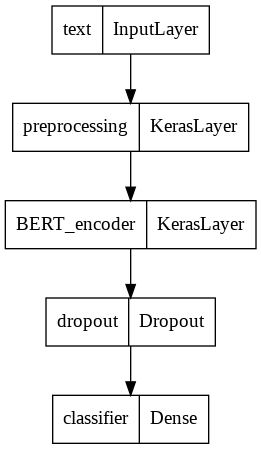

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
# definici√≥n de la funcion de perdida y la metrica a utilizar
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# parametrizaci√≥n
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compilaci√≥n del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
## entrenamiento del modelo con todas la noticias.
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/20
67/67 [==============================] - 92s 1s/step - loss: 0.6804 - binary_accuracy: 0.5465 - val_loss: 0.6447 - val_binary_accuracy: 0.6314
Epoch 2/20
67/67 [==============================] - 68s 1s/step - loss: 0.6439 - binary_accuracy: 0.6791 - val_loss: 0.6258 - val_binary_accuracy: 0.6616
Epoch 3/20
67/67 [==============================] - 68s 1s/step - loss: 0.6173 - binary_accuracy: 0.7272 - val_loss: 0.8653 - val_binary_accuracy: 0.7032
Epoch 4/20
67/67 [==============================] - 68s 1s/step - loss: 0.6261 - binary_accuracy: 0.7504 - val_loss: 0.7637 - val_binary_accuracy: 0.7202
Epoch 5/20
67/67 [==============================] - 68s 1s/step - loss: 0.5397 - binary_accuracy: 0.8249 - val_loss: 0.7587 - val_binary_accuracy: 0.7618
Epoch 6/20
67/67 [==============================] - 68s 1s/step - loss: 0.5725 - binary_accuracy: 0.8160 - val_loss: 0.6018 - val_binary_accuracy:

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


21/21 [==============================] - 7s 321ms/step - loss: 1.2661 - binary_accuracy: 0.7447
Loss: 1.266050934791565
Accuracy: 0.7447130084037781


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


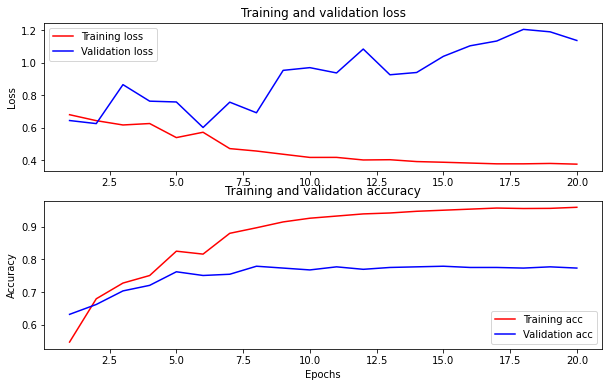

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### BERT con corpus propio sin preprocesar



In [ ]:
# alistamiento de los datos para el entrenamiento con BERT
noticias_falsas=df_base_cp[df_base_cp['Categoria']=='Noticia Falsa']
noticias_verdaderas=df_base_cp[df_base_cp['Categoria']=='Noticia Real']

In [ ]:
new_dataframe_suffle_true=noticias_verdaderas.sample(frac=1)
new_dataframe_suffle_false=noticias_falsas.sample(frac=1)

In [ ]:
new_dataframe_suffle_true['Texto'].iloc[100]

' Mayorqu√≠n citado a audiencia p√∫blica el 3 de febrero.\nEl director del DAPRE, V√≠ctor Mu√±oz, indic√≥ que Andr√©s Mayorqu√≠n, ex exasesor presidencial, fue llamado a rendir declaratoria el pr√≥ximo 3 de febrero, por el presunto caso de tr√°fico de influencias. '

In [ ]:
new_dataframe_suffle_false

Categoria                                              Texto  \
510  Noticia Falsa  LUTO NACIONAL Acaba de ocurrir un terrible acc...   
555  Noticia Falsa  GOBIERNO DE EEUU SANCIONA A SANTOS POR ESTA ES...   
228  Noticia Falsa  No est√°s obligado a vacunarte \nAcuerdo de N√∫r...   
207  Noticia Falsa  LA TRISTE HISTORIA DEL BLACK FRIDAY  Durante e...   
310  Noticia Falsa  5 empleados del Ara en coma, 4 polic√≠as muerto...   
..             ...                                                ...   
71   Noticia Falsa  ATENCI√ìN.\n\nLa Pandemia, bajo la √≥ptica de Ma...   
196  Noticia Falsa  el Alto Comisionado para la Paz, Miguel Ceball...   
80   Noticia Falsa  Un ojo vale m√°s que una protesta. Mi consejo e...   
161  Noticia Falsa  Timochenko confirma regreso de Iv√°n M√°rquez al...   
536  Noticia Falsa  La riqueza es de quien la necesita, no de quie...   

                                        Processed_Text  
510  luto nacional acaba ocurrir terrible accidente...  
555  gobierno eeuu sanciona santos escandalosa noti...  
228  obligado vacunarte acuerdo nuremberg obligar v...  
207  triste historia black friday comercio esclavos...  
310  empleados ara coma policias muertos uniformado...  
..                                                 ...  
71   atencion pandemia optica manuel elkin patarrol...  
196  alto comisionado paz miguel ceballos evaluacio...  
80   ojo vale protesta consejo salgan marchar novie...  
161  timochenko confirma regreso ivan marquez narco...  
536  riqueza necesita crea frase carrera apareciero...  

[317 rows x 3 columns]

In [ ]:
print(new_dataframe_suffle_true.shape)
print(new_dataframe_suffle_false.shape)

(317, 3)
(317, 3)


In [ ]:
test_true=new_dataframe_suffle_true.iloc[:60,:]
test_false=new_dataframe_suffle_false.iloc[:60,:]
training_true=new_dataframe_suffle_true.iloc[60:,:]
training_false=new_dataframe_suffle_false.iloc[60:,:]
print(test_true.shape)
print(test_false.shape)
print(training_true.shape)
print(training_false.shape)

(60, 3)
(60, 3)
(257, 3)
(257, 3)


In [ ]:
test_true

Categoria                                              Texto  \
290  Noticia Real   Expectativa por protagonismo femenino en elec...   
24   Noticia Real  La¬†Procuradur√≠a¬†revel√≥ que despu√©s de revisar ...   
396  Noticia Real  Vulnerabilidad al cambio clim√°tico del sector ...   
100  Noticia Real  La Polic√≠a Nacional espa√±ola detuvo a un colom...   
358  Noticia Real  √ìscar Iv√°n Zuluaga da positivo a covid-20\nEl ...   
458  Noticia Real  \nEl secretario de Seguridad de Cali, Carlos J...   
40   Noticia Real  La decisi√≥n la confirm√≥ la representante legal...   
255  Noticia Real  Partidos y coaliciones inician presentaci√≥n de...   
339  Noticia Real  Lo √∫ltimo: Diego Cadena, suspendido 3 a√±os par...   
347  Noticia Real  Comienza inscripci√≥n de candidatos a la presid...   
143  Noticia Real  \nEste martes, 14 de diciembre de 2021, el cor...   
346  Noticia Real   Logramos regular el uso de las armas traum√°ti...   
367  Noticia Real  Fuad Char hace campa√±a en La Mojana sucre√±a\nL...   
606  Noticia Real  Preocupaci√≥n por aumento de ri√±as en los plant...   
8    Noticia Real  Canciller propone a Cuba agenda de mutua confi...   
481  Noticia Real  El senador Roy Barreras, quien aspira nuevamen...   
483  Noticia Real  Colombia est√° a cuatro meses de votar en las u...   
447  Noticia Real  Comunidad aleda√±a a la carrilera del tren en C...   
21   Noticia Real  Al entrar en la recta final de su mandato, el ...   
378  Noticia Real   Claudia L√≥pez descarta la propuesta de 'pico ...   
110  Noticia Real  El Ej√©rcito Nacional inform√≥ que fue dado de b...   
253  Noticia Real  La carta donde el candidato del Centro Democr√°...   
585  Noticia Real  \nLas alianzas pol√≠ticas cobran fuerza en el p...   
20   Noticia Real  A las 6:00 p.m. se cerr√≥ el plazo para la insc...   
91   Noticia Real  Innovaci√≥n en el manejo del trauma: Esternotom...   
365  Noticia Real  Germ√°n Var√≥n se adhiere a la campa√±a de Alejan...   
10   Noticia Real  Cadena perpetua para los corruptos: Gilberto T...   
372  Noticia Real   Dian y Dane llegan a nuevo acuerdo de acceso ...   
127  Noticia Real  \nEn las √∫ltimas horas, las autoridades han in...   
96   Noticia Real  Un ataque sicarial en zona rural de Buenos Air...   
610  Noticia Real  Autoridades intensifican medidas preventivas c...   
356  Noticia Real  Conservadores proclamaron a David Barguil como...   
580  Noticia Real  \nLuego de que la Registradur√≠a Nacional y el ...   
619  Noticia Real  Elecciones 2022: los municipios que m√°s partic...   
130  Noticia Real  Por medio de un video revelado por Blu Radio, ...   
120  Noticia Real  \nUn hombre fue capturado en el momento en que...   
462  Noticia Real  \nLa Organizaci√≥n Tejido de Defensa de la Vida...   
271  Noticia Real   As√≠ podr√° acceder a los incentivos por genera...   
376  Noticia Real   Debate presidencial: qu√© dijeron los candidat...   
123  Noticia Real  \nDurante los operativos realizados por la Pol...   
2    Noticia Real  Marta Luc√≠a Ram√≠rez se queja por servicio en e...   
264  Noticia Real  CNE estudia revocar candidatura de Jorge Tovar...   
112  Noticia Real  \nEn la tarde del s√°bado 15 de enero, se prese...   
604  Noticia Real  Se cumplen 20 a√±os del magnicidio de Monse√±or ...   
295  Noticia Real   Investigar√°n a Claudia L√≥pez por participaci√≥...   
31   Noticia Real  El pastor cristiano Alfredo Saade decidi√≥ apar...   
97   Noticia Real  El Centro Cibern√©tico de la Dij√≠n inform√≥ que ...   
92   Noticia Real  El mundo atraviesa por un momento decisivo en ...   
449  Noticia Real  \nGracias a la acci√≥n conjunta del Cuerpo T√©cn...   
380  Noticia Real   As√≠ ser√° el primer debate entre 10 aspirantes...   
146  Noticia Real  Este lunes, 13 de diciembre, en presencia del ...   
594  Noticia Real  Ordenan habilitar vacunaci√≥n durante eleccione...   
364  Noticia Real  Cristianos coquetean con el Equipo por Colombi...   
292  Noticia Real   Registradur√≠a adquiri√≥ software de escrut

In [ ]:
len_noticias_falsas=len(training_false)
len_noticias_verdaderas=len(training_true)
len_noticias_falsas_test=len(test_false)
len_noticias_verdaderas_test=len(test_true)

In [ ]:
print(len(training_false))
print(len(training_true))
print(len(test_false))
print(len(test_true))

257
257
60
60


In [ ]:
training_false=training_false.reset_index(drop=True)
training_true=training_true.reset_index(drop=True)

In [ ]:
test_false=test_false.reset_index(drop=True)
test_true=test_true.reset_index(drop=True)

In [ ]:
## ver el directorio actual de trabajo
import os
print(os.getcwd())
#os.chdir(os.getcwd())

/content


In [ ]:
# para borra los directorios
import shutil
os.chdir('/content')
#os.chdir('news')
shutil.rmtree('news')

In [ ]:
# crear  los directorios y separar las noticias de manera individual
os.makedirs('news')
os.chdir('news')
os.makedirs('train')
os.chdir('train')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_falsas), range(len_noticias_falsas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_false['Texto'][i])

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('train')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas), range(len_noticias_verdaderas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_true['Texto'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.makedirs('test')
os.chdir('test')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_false['Texto'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('test')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_true['Texto'][i])
os.chdir('/content')

In [ ]:
# para borra los directorios
#import shutil
#os.chdir('/content')
#os.chdir('news')
#shutil.rmtree('test')

In [ ]:
## se leen las noticias utilizando las utilidades de keras
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'news/test',
    batch_size=batch_size)

label_class_names = test_ds.class_names

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 514 files belonging to 2 classes.
Using 412 files for training.
Found 514 files belonging to 2 classes.
Using 102 files for validation.
Found 120 files belonging to 2 classes.


In [ ]:
# se define la arquitectura de la red neuronal utilizando a BERT para que haga parte del modelo (Fine Tunning)
tf.keras.backend.clear_session()
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='relu', name='classifier')(net)
  return tf.keras.Model(text_input, net)

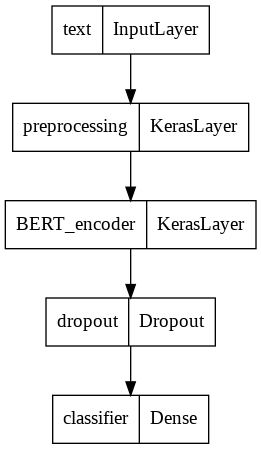

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
# definici√≥n de la funcion de perdida y la metrica a utilizar
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# parametrizaci√≥n
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compilaci√≥n del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
## entrenamiento del modelo con todas la noticias.
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/20
13/13 [==============================] - 39s 994ms/step - loss: 0.6933 - binary_accuracy: 0.5146 - val_loss: 0.6931 - val_binary_accuracy: 0.4510
Epoch 2/20
13/13 [==============================] - 12s 947ms/step - loss: 0.6966 - binary_accuracy: 0.5316 - val_loss: 0.6432 - val_binary_accuracy: 0.5588
Epoch 3/20
13/13 [==============================] - 13s 969ms/step - loss: 0.5765 - binary_accuracy: 0.7937 - val_loss: 0.4053 - val_binary_accuracy: 0.9412
Epoch 4/20
13/13 [==============================] - 13s 976ms/step - loss: 0.4288 - binary_accuracy: 0.9587 - val_loss: 0.4842 - val_binary_accuracy: 0.9216
Epoch 5/20
13/13 [==============================] - 13s 990ms/step - loss: 0.4312 - binary_accuracy: 0.9660 - val_loss: 0.4622 - val_binary_accuracy: 0.9412
Epoch 6/20
13/13 [==============================] - 13s 991ms/step - loss: 0.3937 - binary_accuracy: 0.9830 - val_loss: 0.5097 - va

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


4/4 [==============================] - 1s 304ms/step - loss: 0.4613 - binary_accuracy: 0.9583
Loss: 0.46129265427589417
Accuracy: 0.9583333134651184


In [ ]:
#labels =  np.array([])
#predictions =  np.array([])
#for x, y in test_ds:
#  predictions = np.concatenate([predictions, classifier_model.predict(x)])
#  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])


In [ ]:
prediccion=classifier_model.predict(test_ds)

In [ ]:
prediccion

In [ ]:
#y_predict=(prediccion>0.5)
#confusion_matrix(labels_test,y_predict)

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


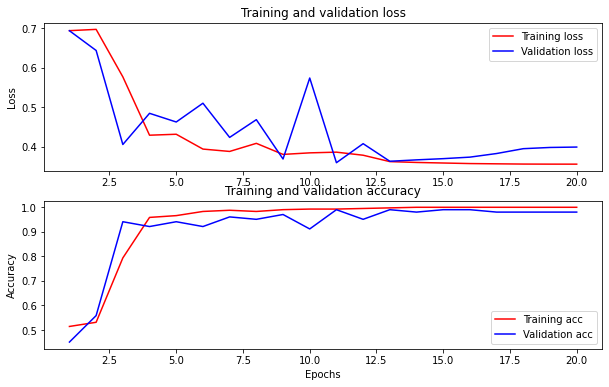

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'noticiasColombianas'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)


INFO:tensorflow:Assets written to: ./noticiasColombianas_bert/assets


INFO:tensorflow:Assets written to: ./noticiasColombianas_bert/assets


In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def pruebas(df,results):
  df_noticias=[]
  for i in tqdm(range(len(df))):
    if(results[i][0]>0.5):
      df_noticias.append(True)
    else:
      df_noticias.append(False)
  return df_noticias

In [ ]:
def pruebasPrediccion(inputs, results):
    return results[i][0]
             

In [ ]:
def classification_news_(df):
  df_noticias=[]
  for noticia in tqdm(df):
    df_noticias.append(detection_fake_news_(noticia))
  return df_noticias

In [ ]:
df_testNoticiasColombianas

Etiqueta                                              Texto
0      False  Posibles narcotraficantes est√°n financiando ca...
1      False   En una entrevista reciente, se le pregunt√≥ al...
2      False  En una iglesia ucraniana que qued√≥ totalmente ...
3      False  las palomas tienen m√°s prote√≠nas, en Suecia co...
4      False   Q tristeza q tengan q pagar gente inocente, y...
5      False  ¬øAhora entienden por qu√© solo aparecen votos p...
6      False  Si Usted depende para VIVIR del Arriendo de un...
7      False  Los coste√±os son la poblaci√≥n menos intelectua...
8      False  Esta es la verdadera raz√≥n C del fallo sobre e...
9      False  LUTO NACIONAL Acaba de ocurrir un terrible acc...
10     False  en plenaria del senado intentar√°n quitarle la ...
11     False  Se anul√≥ la vacunaci√≥n universal. Una gran vic...
12     False  Recuerdan lo de las 10 millones de firmas para...
13     False  FURIBUNDA: Ante el pedido de no relacionarse c...
14     False  Teodora, siempre he esperado este momento en q...
15      True   Mancharon el uniforme: Molano sobre militares...
16      True   Vamos a unir a Colombia: Guti√©rrez agradece a...
17      True   Las ideas de presidenciables para reducir la ...
18      True   EE.UU. preocupado sobre posible injerencia en...
19      True   Juez no precluy√≥ investigaci√≥n contra Uribe p...
20      True   Grupo armado irrumpi√≥ en la Universidad Nacio...
21      True   Ent√©rese: por aqu√≠ ser√°n las marchas de este ...
22      True   Cada vendedor informal tendr√° un espacio de 1...
23      True   Cancilleres de Colombia y Turqu√≠a fortalecen ...
24      True  Por medio del Decreto 559 de abril de 2022, el...
25      True  El ministro de Defensa, Diego Molano, asisti√≥ ...
26      True  El presidente de la Rep√∫blica, Iv√°n Duque, afi...
27      True  Atrav√©s de su cuenta de Twitter, el expresiden...
28      True  Este jueves el alcalde de Cali, Jorge Iv√°n Osp...
29      True  \nFrancia M√°rquez, f√≥rmula vicepresidencial de...
30      True  En la noche del domingo 24 de abril, se llev√≥ ...
31      True  Un acalorado debate en la C√°mara de Representa...

In [ ]:
reloaded_results = tf.sigmoid(reloaded_model(tf.constant(df_testNoticiasColombianas['Texto'])))
print('Results from the saved model:')
df_result_BERT=pruebas(df_testNoticiasColombianas['Texto'], reloaded_results)

Results from the saved model:


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:00<00:00, 84.59it/s]


In [ ]:
val_label=df_testNoticiasColombianas['Etiqueta']

Text(39.49999999999999, 0.5, 'Predicted')

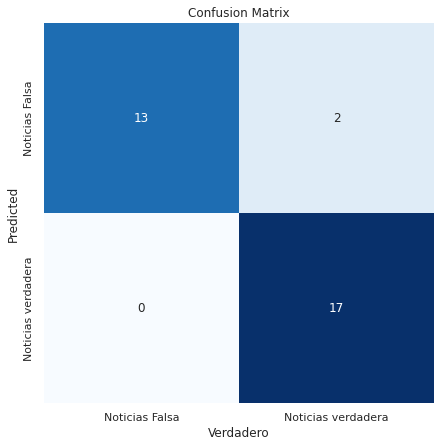

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(val_label, df_result_BERT)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf


Noticias Falsa  Noticias verdadera
Noticias Falsa                  13                   2
Noticias verdadera               0                  17

In [ ]:
print(classification_report(val_label,df_result_BERT, target_names=['Noticia verdadera','Noticia Falsa']))


                   precision    recall  f1-score   support

Noticia verdadera       1.00      0.87      0.93        15
    Noticia Falsa       0.89      1.00      0.94        17

         accuracy                           0.94        32
        macro avg       0.95      0.93      0.94        32
     weighted avg       0.94      0.94      0.94        32



### BERT con corpus unido sin preprocesar



In [ ]:
# alistamiento de los datos para el entrenamiento con BERT
noticias_falsas=df_base[df_base['Categoria']=='Noticia Falsa']
noticias_verdaderas=df_base[df_base['Categoria']=='Noticia Real']

In [ ]:
new_dataframe_suffle_true=noticias_verdaderas.sample(frac=1)
new_dataframe_suffle_false=noticias_falsas.sample(frac=1)

In [ ]:
new_dataframe_suffle_true['Texto'].iloc[360]

'Respetamos y veneramos a la Virgen de Guadalupe: AMLO\nLa difusi√≥n a trav√©s de redes sociales de volantes en que supuestamente el partido Morena acusa a la Iglesia Cat√≥lica de ser parte de la llamada "mafia del poder" fue rechazada por Andr√©s Manuel L√≥pez Obrador.\nEl candidato de la coalici√≥n Juntos Haremos Historia a la presidencia de la Rep√∫blica dijo que su movimiento social es incluyente y respeta la libertad de credos y la veneraci√≥n a la Virgen de Guadalupe.\nEst√°n pasando ahora unos volantes que dicen que estamos en contra de La Virgen de Guadalupe, es una campa√±a vil, sucia.\n"Somos respetuosos de la libertad de creencia", puntualiz√≥ L√≥pez Obrador.\nLos volantes fueron difundidos mediante fotograf√≠as en redes sociales, y en ellos se plantea que la iglesia fanatiza a la poblaci√≥n, pr√°ctica que Morena impedir√≠a en caso que el tabasque√±o obtenga la presidencia.\nYo estoy muy consciente que el pueblo de M√©xico tiene veneraci√≥n por la Virgen de Guadalupe, tiene 

In [ ]:
new_dataframe_suffle_false

Unnamed: 0      Categoria  \
2313        1003  Noticia Falsa   
757          123  Noticia Falsa   
2300         990  Noticia Falsa   
3155        1845  Noticia Falsa   
2695        1385  Noticia Falsa   
...          ...            ...   
783          149  Noticia Falsa   
219          219  Noticia Falsa   
2559        1249  Noticia Falsa   
52            52  Noticia Falsa   
2153         843  Noticia Falsa   

                                                  Texto  \
2313  Incre√≠ble pero cierto. En unos grandes almacen...   
757   Facebook cobrar√° manejo de cuenta si no se cub...   
2300  HOLA CONTACTOS DE FACEBOOK, ESTA RATA DE ALCAN...   
3155  Este video de polic√≠as cogiendo m√≥viles y de t...   
2695  Matan a la madre, la descuartizan y a√∫n con la...   
...                                                 ...   
783   PAPA FRANCISCO ANUNCIA LANZAMIENTO DE APP PARA...   
219   Buenas noticias! Vacuna contra virus Carona li...   
2559  La transmisi√≥n de un caso de sarna a una agent...   
52    De ultima hora Fuerte Sismo de 82 grados sacud...   
2153  En la actualidad, podemos ver c√≥mo son cada ve...   

                                         Processed_Text         Codigo  
2313  increible almacenes ciudad alemana turba musul...  Noticia Falsa  
757   facebook cobrara manejo cubre minimo post cono...  Noticia Falsa  
2300  hola contactos facebook rata alcantarilla qued...  Noticia Falsa  
3155  video policias cogiendo moviles tienda corrien...  Noticia Falsa  
2695  matan madre descuartizan carne caliente coloca...  Noticia Falsa  
...                                                 ...            ...  
783   papa francisco anuncia lanzamiento app ligar i...  Noticia Falsa  
219   noticias vacuna virus carona lista capaz curar...  Noticia Falsa  
2559  transmision caso sarna agente autoridad centro...  Noticia Falsa  
52    hora fuerte sismo grados sacude argentina imag...  Noticia Falsa  
2153  actualidad personas padeciendo cancer afecta i...  Noticia Falsa  

[1655 rows x 5 columns]

In [ ]:
print(new_dataframe_suffle_true.shape)
print(new_dataframe_suffle_false.shape)

(1655, 5)
(1655, 5)


In [ ]:
test_true=new_dataframe_suffle_true.iloc[:331,:]
test_false=new_dataframe_suffle_false.iloc[:331,:]
training_true=new_dataframe_suffle_true.iloc[331:,:]
training_false=new_dataframe_suffle_false.iloc[331:,:]
print(test_true.shape)
print(test_false.shape)
print(training_true.shape)
print(training_false.shape)

(331, 5)
(331, 5)
(1324, 5)
(1324, 5)


In [ ]:
test_true

Unnamed: 0     Categoria  \
1435         125  Noticia Real   
1881         571  Noticia Real   
1528         218  Noticia Real   
1700         390  Noticia Real   
3243        1933  Noticia Real   
...          ...           ...   
3258        1948  Noticia Real   
1017         383  Noticia Real   
3226        1916  Noticia Real   
2929        1619  Noticia Real   
1493         183  Noticia Real   

                                                  Texto  \
1435   El servicio municipal gratuito de Teleasisten...   
1881  El cardenal australiano George Pell , ex n√∫mer...   
1528  Un autob√∫s en Sevilla con la publicidad de la ...   
1700  Cae una red que sustra√≠a menores de un centro ...   
3243   Ha asegurado que ¬´va a analizarqu√© est√° ocurr...   
...                                                 ...   
3258   La creaci√≥n de empleo entre julio y septiembr...   
1017  Enrique Ochoa dej√≥ este mi√©rcoles la dirigenci...   
3226   La producci√≥n de casta√±a ha ca√≠do un 25 % en ...   
2929  Socialdem√≥cratas y ultraderecha votan juntos y...   
1493   Lewis Hamilton, tras el triunfo del domingo e...   

                                         Processed_Text        Codigo  
1435  servicio municipal gratuito teleasistencia cas...  Noticia Real  
1881  cardenal australiano george pell numero vatica...  Noticia Real  
1528  autobus sevilla publicidad junta violencia gen...  Noticia Real  
1700  cae red sustraia menores centro almeria trafic...  Noticia Real  
3243  asegurado analizarque ocurriendo datos acorde ...  Noticia Real  
...                                                 ...           ...  
3258  creacion julio septiembre resentido comparacio...  Noticia Real  
1017  enrique ochoa miercoles dirigencia partido rev...  Noticia Real  
3226  produccion castana caido galicia calor otono e...  Noticia Real  
2929  socialdemocratas ultraderecha votan juntos tum...  Noticia Real  
1493  lewis hamilton triunfo domingo hungarore calif...  Noticia Real  

[331 rows x 5 columns]

In [ ]:
len_noticias_falsas=len(training_false)
len_noticias_verdaderas=len(training_true)
len_noticias_falsas_test=len(test_false)
len_noticias_verdaderas_test=len(test_true)

In [ ]:
print(len(training_false))
print(len(training_true))
print(len(test_false))
print(len(test_true))

1324
1324
331
331


In [ ]:
training_false=training_false.reset_index(drop=True)
training_true=training_true.reset_index(drop=True)

In [ ]:
test_false=test_false.reset_index(drop=True)
test_true=test_true.reset_index(drop=True)

In [ ]:
## ver el directorio actual de trabajo
import os
print(os.getcwd())
#os.chdir(os.getcwd())

/content


In [ ]:
# para borra los directorios
#import shutil
#os.chdir('/content')
#os.chdir('news')
#shutil.rmtree('news')

In [ ]:
# crear  los directorios y separar las noticias de manera individual
os.makedirs('news')
os.chdir('news')
os.makedirs('train')
os.chdir('train')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_falsas), range(len_noticias_falsas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_false['Texto'][i])

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('train')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas), range(len_noticias_verdaderas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_true['Texto'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.makedirs('test')
os.chdir('test')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_false['Texto'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('test')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_true['Texto'][i])
os.chdir('/content')

In [ ]:
# para borra los directorios
#import shutil
#os.chdir('/content')
#os.chdir('news')
#shutil.rmtree('test')

In [ ]:
## se leen las noticias utilizando las utilidades de keras
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'news/test',
    batch_size=batch_size)

label_class_names = test_ds.class_names

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 2648 files belonging to 2 classes.
Using 2119 files for training.
Found 2648 files belonging to 2 classes.
Using 529 files for validation.
Found 662 files belonging to 2 classes.


In [ ]:
# se define la arquitectura de la red neuronal utilizando a BERT para que haga parte del modelo (Fine Tunning)
tf.keras.backend.clear_session()
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='relu', name='classifier')(net)
  return tf.keras.Model(text_input, net)

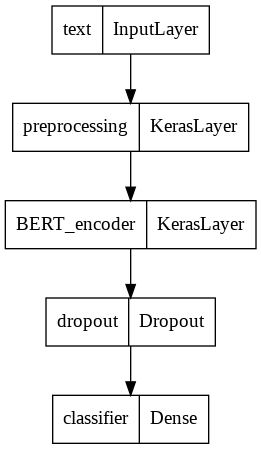

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
# definici√≥n de la funcion de perdida y la metrica a utilizar
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# parametrizaci√≥n
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compilaci√≥n del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
## entrenamiento del modelo con todas la noticias.
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/20
67/67 [==============================] - 89s 981ms/step - loss: 0.6961 - binary_accuracy: 0.4974 - val_loss: 0.6931 - val_binary_accuracy: 0.4953
Epoch 2/20
67/67 [==============================] - 67s 995ms/step - loss: 0.6932 - binary_accuracy: 0.5012 - val_loss: 0.6931 - val_binary_accuracy: 0.4953
Epoch 3/20
67/67 [==============================] - 67s 1s/step - loss: 0.7019 - binary_accuracy: 0.5474 - val_loss: 0.6603 - val_binary_accuracy: 0.5784
Epoch 4/20
67/67 [==============================] - 68s 1s/step - loss: 0.6257 - binary_accuracy: 0.7135 - val_loss: 0.6425 - val_binary_accuracy: 0.7732
Epoch 5/20
67/67 [==============================] - 68s 1s/step - loss: 0.6365 - binary_accuracy: 0.7286 - val_loss: 0.5714 - val_binary_accuracy: 0.7921
Epoch 6/20
67/67 [==============================] - 68s 1s/step - loss: 0.5335 - binary_accuracy: 0.8188 - val_loss: 0.6332 - val_binary_acc

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


21/21 [==============================] - 7s 338ms/step - loss: 1.2416 - binary_accuracy: 0.8278
Loss: 1.2416189908981323
Accuracy: 0.8277945518493652


In [ ]:
clasif_BERT=classifier_model.predict(test_ds)

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


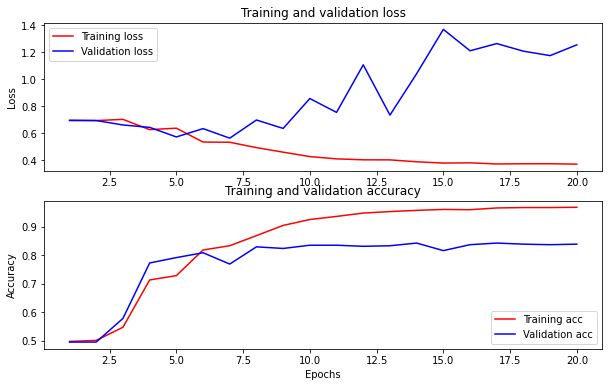

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'noticias'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)


INFO:tensorflow:Assets written to: ./noticias_bert/assets


INFO:tensorflow:Assets written to: ./noticias_bert/assets


In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def pruebas(df,results):
  df_noticias=[]
  for i in tqdm(range(len(df))):
    if(results[i][0]>0.5):
      df_noticias.append(True)
    else:
      df_noticias.append(False)
  return df_noticias
  
def pruebasPrediccion(inputs, results):
    return results[i][0]

def classification_news_(df):
  df_noticias=[]
  for noticia in tqdm(df):
    df_noticias.append(detection_fake_news_(noticia))
  return df_noticias

In [ ]:
df_testNoticiasMejicanas

CATEGORY                                               TEXT
0        True  El control de la Covid-19 no es s√≥lo un tema d...
1       False  El Gobierno de Pedro S√°nchez y Pablo Iglesias ...
2        True  Las tres federaciones que agrupan al 90% de la...
3       False  Se han dado a conocer los datos electorales pr...
4        True  La primera fase del censo ser√° virtual y solo ...
..        ...                                                ...
567      True  El Instituto de Diagn√≥stico y Referencia Epide...
568     False  La hija del rey Felipe y de la reina Letizia y...
569     False  Evidentemente, Barak Obama ha sido arrestado e...
570      True  El Ministerio de Sanidad ha actualizado los da...
571     False  Fue en el mes de febrero de 2014 cuando la rev...

[572 rows x 2 columns]

In [ ]:
testNotciasColombianas=pd.read_excel("fakeNewsColombia.xlsx")

In [ ]:
testNotciasColombianas.head()

Etiqueta                                              Texto
0     False  Posibles narcotraficantes est√°n financiando ca...
1     False   En una entrevista reciente, se le pregunt√≥ al...
2     False  En una iglesia ucraniana que qued√≥ totalmente ...
3     False  las palomas tienen m√°s prote√≠nas, en Suecia co...
4     False   Q tristeza q tengan q pagar gente inocente, y...

In [ ]:
reloaded_results = tf.sigmoid(reloaded_model(tf.constant(testNotciasColombianas['Texto'])))
print('Results from the saved model:')
df_result_BERT=pruebas(testNotciasColombianas['Texto'], reloaded_results)

Results from the saved model:


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:00<00:00, 89.78it/s]


In [ ]:
real_label=testNotciasColombianas['Etiqueta']

In [ ]:
print(type(df_result_BERT))
print(type(real_label))

<class 'list'>
<class 'pandas.core.series.Series'>


Text(39.49999999999999, 0.5, 'Predicted')

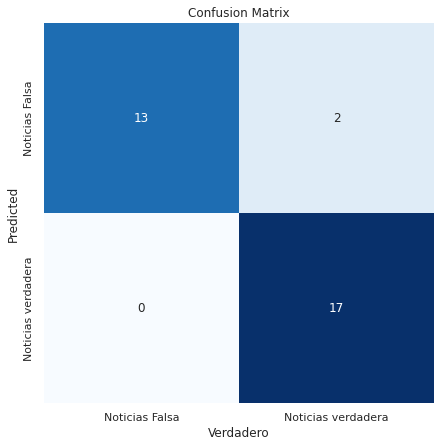

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(real_label, df_result_BERT)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

Noticias Falsa  Noticias verdadera
Noticias Falsa                  13                   2
Noticias verdadera               0                  17

In [ ]:
print(classification_report(real_label,df_result_BERT, target_names=['Noticia verdadera','Noticia Falsa']))

                   precision    recall  f1-score   support

Noticia verdadera       1.00      0.87      0.93        15
    Noticia Falsa       0.89      1.00      0.94        17

         accuracy                           0.94        32
        macro avg       0.95      0.93      0.94        32
     weighted avg       0.94      0.94      0.94        32



In [ ]:
archivo_zip = shutil.make_archive("modelo", 
                                  "zip", 
                                  base_dir ="noticias_bert")

In [ ]:
archivo_zip = shutil.make_archive("modeloFakeNewsDetecColombia", 
                                  "zip", 
                                  base_dir ="noticiasColombianas_bert")

#**Evaluaci√≥n**

###**Evaluaci√≥n de Modelos con Corpus Propio**

In [ ]:
listas_cp=[["Random Forest",accuracy_randomforest_cp],["Naive Bayes",accuracy_nb_cp],["SVC",accuracy_svc_cp],["Logistic Regression",accuracy_logistic_cp],["XGBoost",accuracy_xgb_cp],
           ["Neural Network",accuracy_nn_cp]]
df_listas_cp=pd.DataFrame(listas_cp,columns=["Modelos","M√©trica - Accuracy"])
df_listas_cp
df_listas_cp.style.set_properties(**{'border': '1.3px solid black','text-align': 'center',
                          'color': '#000000'})

###**Evaluaci√≥n de Modelos con el Corpus Mejorado**

In [ ]:
listas=[["Random Forest",accuracy_randomforest],["Naive Bayes",accuracy_nb],["SVC",accuracy_svc],["Logistic Regression",accuracy_logistic],["XGBoost",accuracy_xgb],
         ["Neural Network",accuracy_nn]]
df_listas=pd.DataFrame(listas,columns=["Modelos","M√©trica - Accuracy"])
df_listas
df_listas.style.set_properties(**{'border': '1.3px solid black','text-align': 'center',
                          'color': '#FFFFFF'})

# **Pruebas**

In [ ]:
def detection_fake_news_cp(news):
    news=text_preprocessing(news)
    input_data = [news]
    vectorized_input_data = tfidf_cp.transform(input_data)
    prediction = clf_cp.predict(vectorized_input_data)
    prediction_proba = clf_cp.predict_proba(vectorized_input_data)
    if prediction==0:
      return True
    else:
      return False

In [ ]:
def detection_fake_news_(news):
    news=text_preprocessing(news)
    input_data = [news]
    vectorized_input_data = tfidf.transform(input_data)
    prediction = clf.predict(vectorized_input_data)
    prediction_proba = clf.predict_proba(vectorized_input_data)
    if prediction==0:
      return True
    else:
      return False


In [ ]:
real_label=testNotciasColombianas['Etiqueta']

In [ ]:
def classification_news_twitter(accountname_twitter,count_tweets):
  df_temp_tweets=get_tweets(api,accountname_twitter,count_tweets,False)
  for tweet in df_temp_tweets:
    df_news_classified.append(detection_fake_news_(tweet))
  return df_news_classified
  

In [ ]:
def classification_news_cp(df):
  df_noticias_cp=[]
  for noticia in tqdm(df):
    df_noticias_cp.append(detection_fake_news_cp(noticia))
  return df_noticias_cp

In [ ]:
def classification_news_(df):
  df_noticias=[]
  for noticia in tqdm(df):
    df_noticias.append(detection_fake_news_(noticia))
  return df_noticias

In [ ]:
df_clasificacion_cp=classification_news_cp(testNotciasColombianas['Texto'])

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:14<00:00,  2.16it/s]


In [ ]:
df_clasificacion=classification_news_(testNotciasColombianas['Texto'])

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:06<00:00,  4.86it/s]


In [ ]:
val_label=testNotciasColombianas['Etiqueta']

Text(39.49999999999999, 0.5, 'Predicted')

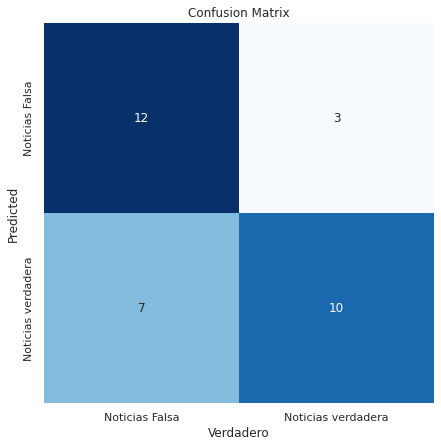

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(val_label, df_clasificacion_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

Noticias Falsa  Noticias verdadera
Noticias Falsa                  12                   3
Noticias verdadera               7                  10

In [ ]:
print(classification_report(val_label,df_clasificacion_cp, target_names=['Noticia verdadera','Noticia Falsa']))

                   precision    recall  f1-score   support

Noticia verdadera       0.63      0.80      0.71        15
    Noticia Falsa       0.77      0.59      0.67        17

         accuracy                           0.69        32
        macro avg       0.70      0.69      0.69        32
     weighted avg       0.70      0.69      0.69        32



Text(39.49999999999999, 0.5, 'Predicted')

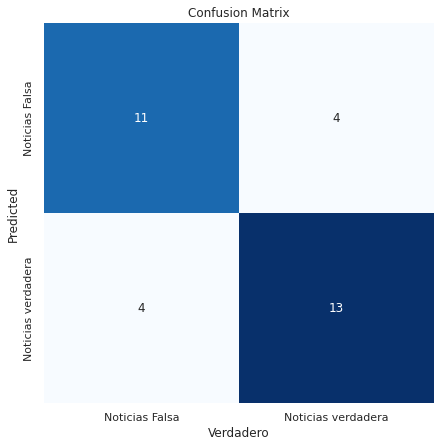

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(val_label, df_clasificacion)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

Noticias Falsa  Noticias verdadera
Noticias Falsa                  11                   4
Noticias verdadera               4                  13

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(val_label,df_clasificacion, target_names=['Noticia verdadera','Noticia Falsa']))

                   precision    recall  f1-score   support

Noticia verdadera       0.73      0.73      0.73        15
    Noticia Falsa       0.76      0.76      0.76        17

         accuracy                           0.75        32
        macro avg       0.75      0.75      0.75        32
     weighted avg       0.75      0.75      0.75        32



In [ ]:
classification_news_twitter("juanmontan0",2)

# **Modelos para producci√≥n**

### Se guardan los modelos para su paso a producci√≥n

# Nueva secci√≥n

In [ ]:
#create_model_production("RF",clf)
create_model_production("NB",best_model_nb)
create_model_production("SVC",best_model_svc)
create_model_production("LR",best_model_logistic)
create_model_production("Xgboost",best_model_xgb)
create_model_production("vectorizer",tfidf)
create_model_production("vectorizer_cp",tfidf_cp)